# Imports

In [1]:
import numpy   as np
import pandas  as pd

from typing import List, Dict

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

In [2]:
from dstoolkit.automl import AutoMLLGBMRegressor, AutoMLLGBMRegressorCV

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Regressor

In [5]:
df = pd.read_csv('../data/global_temperature_time_series.csv', )
df['time'] = pd.to_datetime(df['Year'])
df = df.drop(columns=['Source', 'Year']).rename(columns={'Mean': 'temperature'})

import warnings

import numpy  as np
import pandas as pd

from typing import List, Dict

from scipy.stats import skew, kurtosis


class SimpleLagTimeFeatureCreator:
    
    def __init__(self, windows: List[int] = [2, 3, 4], functions: List[str] = ["mean", "median", "max", "min"]):
        
        """
        Initiate the lag feature creator.
        
        Args:
            windows: List of window sizes for calculating statistics
            functions: List of functions to be applied (mean, median, max, min, etc.)

        Raises:
            UserWarning: If the list of windows contains the value 1
        """
        
        self.windows = windows
        self.functions = functions
        
        self._function_map = {
            'mean': np.mean,
            'median': np.median,
            'max': np.max,
            'min': np.min,
            'sum': np.sum,
            'std': lambda x: np.std(x, ddof=1),
            'diff': np.ptp,
            'kurt': lambda x: kurtosis(x, bias=False),
            'skew': lambda x: skew(x, bias=False),
            'slope': self._calc_slope
        }

        if 1 in self.windows:
            warnings.warn(
                "Window size 1 was found. Windows with size equal to 1 are not recommended for lag/rolling calculations, because they do not aggregate temporal information.",
                UserWarning
            )
            self.windows.remove(1)
    
    def _calc_slope(self, x: np.ndarray) -> float:
        
        """Calculates the slope using least squares."""
        
        return np.polyfit(np.arange(len(x)), x, 1)[0]

    def _create_lag_features(self, series: pd.Series) -> Dict[str, pd.Series]:
        
        """Creates all lagged features for a time series."""
        
        lag_one = series.shift(1)
        features = {f'{series.name}_sum_1_lag': lag_one}
        
        valid_funcs = [func for func in self.functions if func in self._function_map]
        
        for func in valid_funcs:
            
            func_operation = self._function_map[func]
            
            for win in self.windows:
                
                feature_values = lag_one.rolling(window=win, min_periods=2).apply(func_operation, raw=True)
                features[f'{series.name}_{func}_{win}_lag'] = feature_values
        
        return features
    
    def calculate(self, df: pd.DataFrame, target: str, time: str) -> pd.DataFrame:
        
        """
        Calculates all features with temporal lag for the target column.
        
        Args:
            df: Input DataFrame
            target: Name of the target column for feature calculation
            time: Name of the column with temporal data
            
        Returns:
            DataFrame with the new features added
        """
        
        if target not in df.columns:
            raise ValueError(f"Coluna '{target}' não encontrada no DataFrame")
            
        df = df.sort_values(by=time)
        
        features = self._create_lag_features(df[target])
        
        return df.assign(**features)

s = SimpleLagTimeFeatureCreator([2, 3, 4, 5, 6], ["mean", "median", "max", "min", "std", "diff", "slope"])
df1 = s.calculate(df, target='temperature', time='time')

X = df1.drop(columns=['time', 'temperature'])
y = df1[['temperature']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.55, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42)

best_features_reg = [
    'temperature_mean_4_lag',
    'temperature_mean_2_lag',
    'temperature_mean_6_lag',
    'temperature_max_2_lag',
    'temperature_sum_1_lag',
    'temperature_median_6_lag',
    'temperature_slope_3_lag',
    'temperature_min_6_lag',
    'temperature_min_4_lag',
    'temperature_max_6_lag',
    'temperature_slope_5_lag',
    'temperature_slope_2_lag',
    'temperature_slope_4_lag',
    'temperature_slope_6_lag',
    'temperature_std_6_lag',
    'temperature_std_2_lag',
    'temperature_median_3_lag',
    'temperature_min_3_lag']

In [6]:
a = AutoMLLGBMRegressor(
    X_train, y_train, 
    X_valid, y_valid,
    X_test, y_test,
    target='temperature',
    best_features=best_features_reg,
    n_trials=50,
    scoring='r2'
)

In [7]:
a.train()

In [8]:
a.get_metrics()

Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.981188  0.042918  0.033759  8.364095e+11  0.055905   
1   Valid  0.910746  0.090384  0.067664  8.325523e-01  0.119794   
2    Test  0.897021  0.094788  0.070728  4.253654e+12  0.126819   
3   Train  0.977897  0.046626  0.036817  8.316790e+11  0.060598   
4   Valid  0.911422  0.090557  0.067910  8.465628e-01  0.119340   
5    Test  0.899457  0.093677  0.069638  4.285147e+12  0.125310   
6   Train  0.939629  0.077345  0.061649  1.478826e+12  0.100149   
7   Valid  0.918819  0.087401  0.066217  7.972665e-01  0.114248   
8    Test  0.906416  0.089994  0.067415  3.970934e+12  0.120895   

   Explained Variance               Model  
0            0.981188          Base Model  
1            0.911088          Base Model  
2            0.897181          Base Model  
3            0.977897  Best Feature Model  
4            0.911679  Best Feature Model  
5            0.899700  Best Feature Model  
6            0.939629   Best Params Model  
7            0.919082   Best Params Model  
8            0.906730   Best Params Model

base_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.981188  0.042918  0.033759  8.364095e+11  0.055905   
1   Valid  0.910746  0.090384  0.067664  8.325523e-01  0.119794   
2    Test  0.897021  0.094788  0.070728  4.253654e+12  0.126819   

   Explained Variance  
0            0.981188  
1            0.911088  
2            0.897181

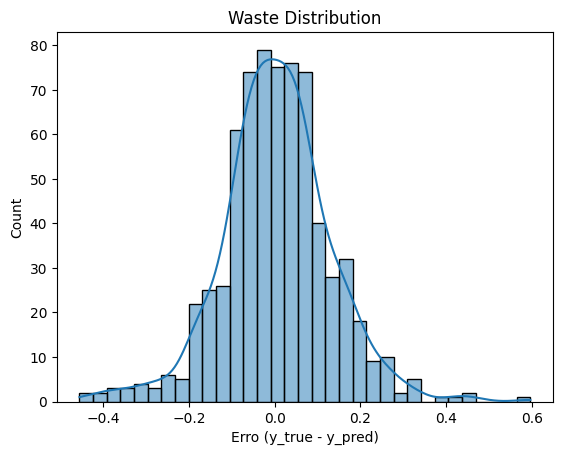

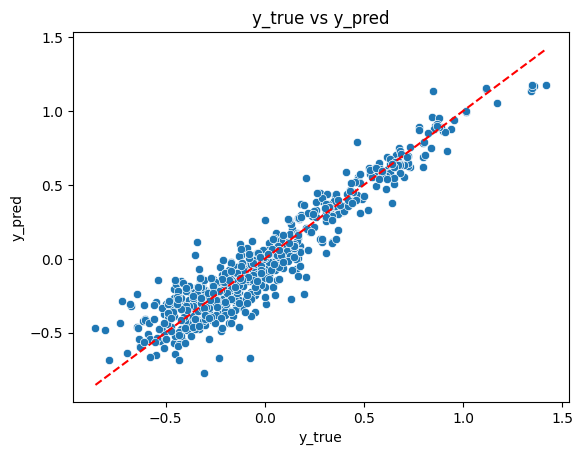

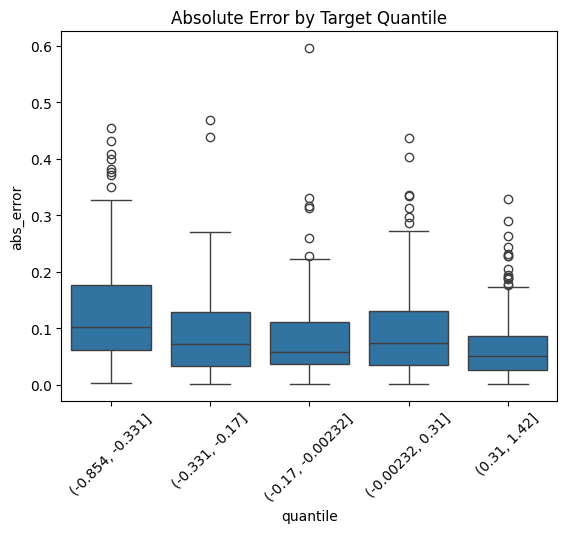

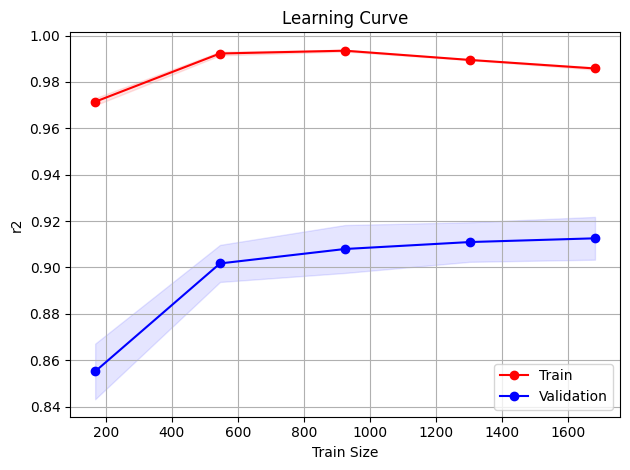

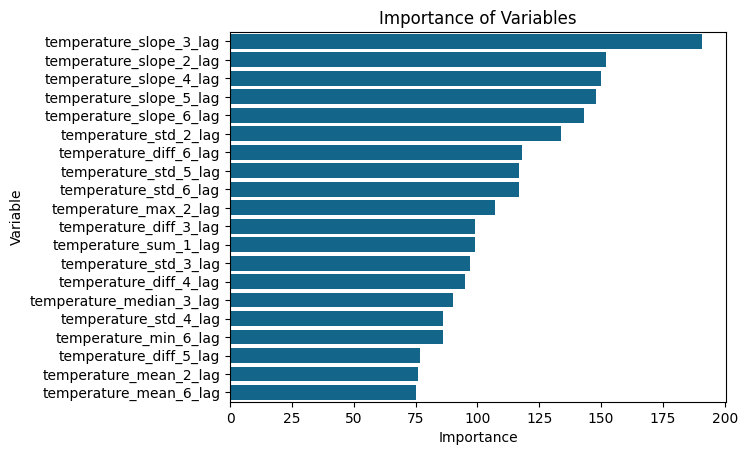

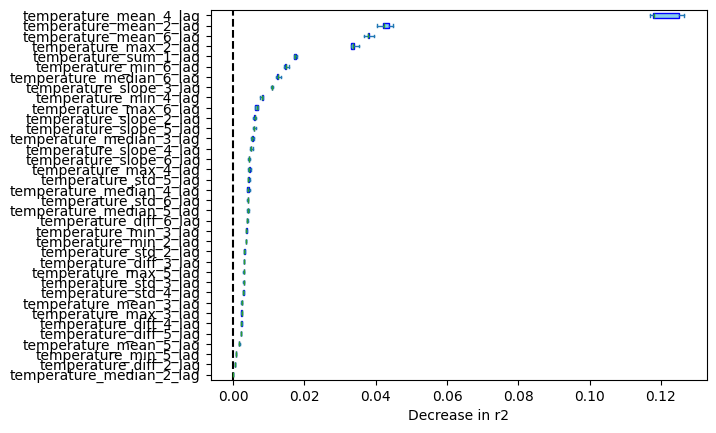

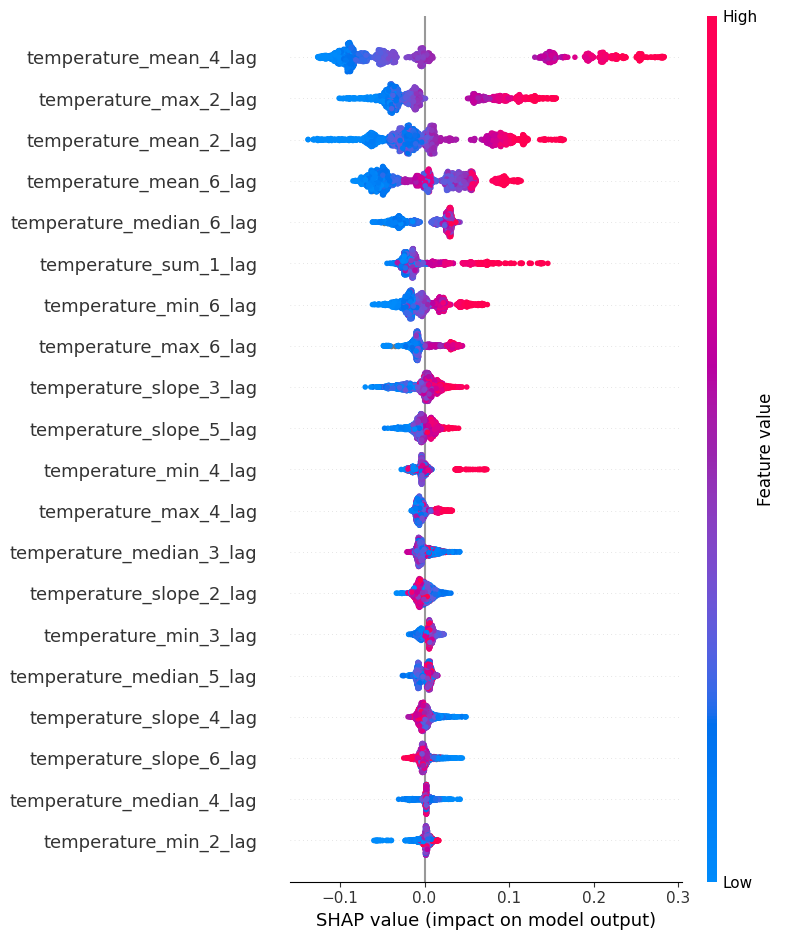

best_feature_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.977897  0.046626  0.036817  8.316790e+11  0.060598   
1   Valid  0.911422  0.090557  0.067910  8.465628e-01  0.119340   
2    Test  0.899457  0.093677  0.069638  4.285147e+12  0.125310   

   Explained Variance  
0            0.977897  
1            0.911679  
2            0.899700

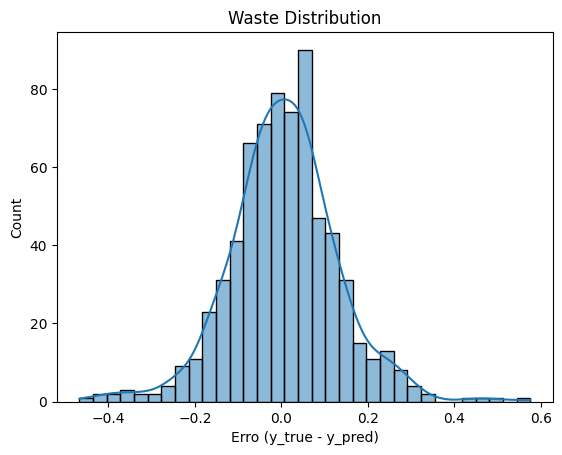

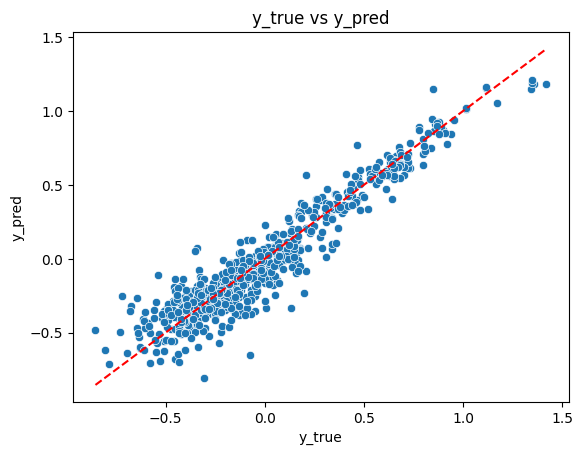

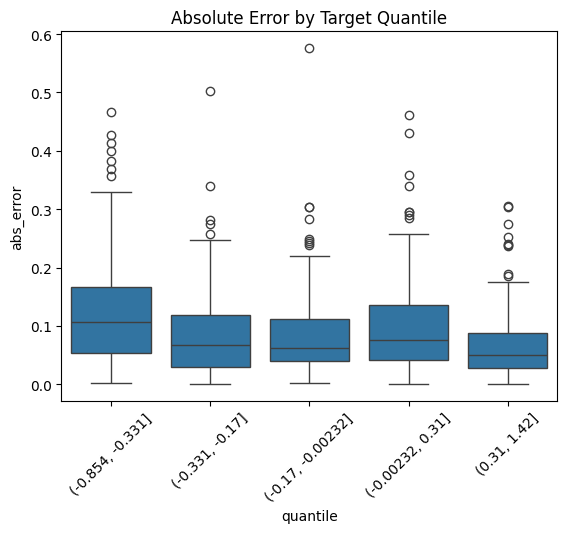

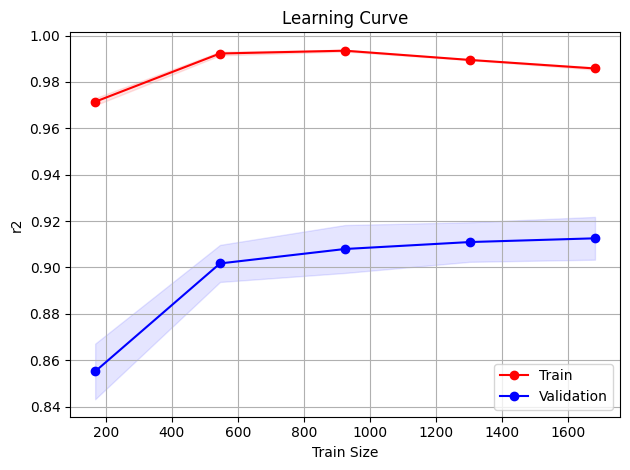

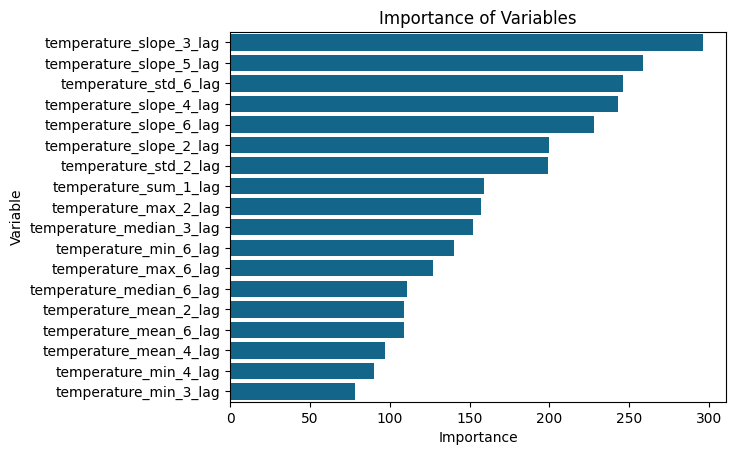

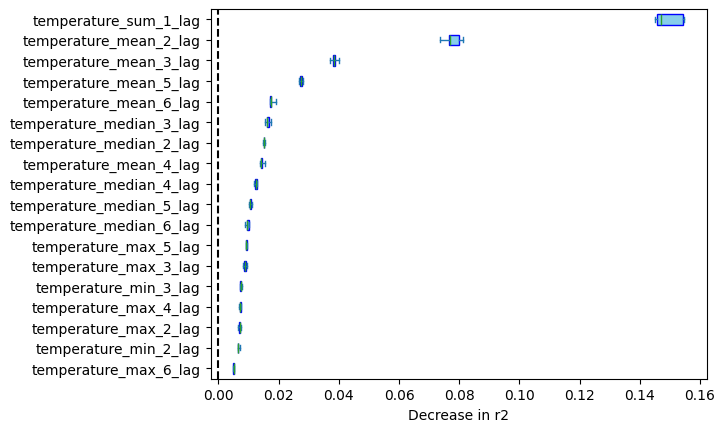

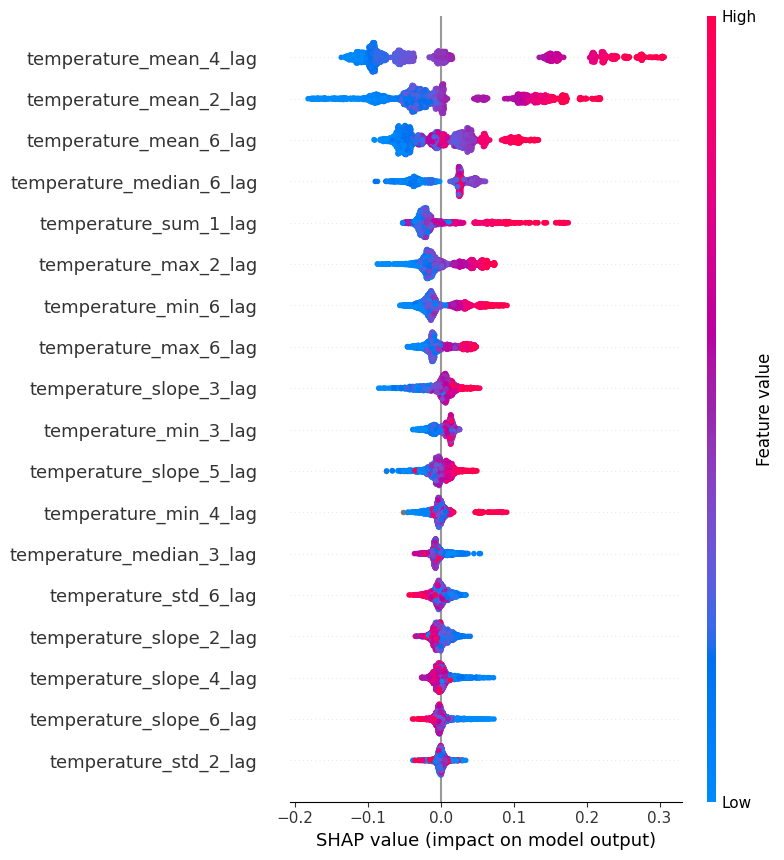

best_params_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.939629  0.077345  0.061649  1.478826e+12  0.100149   
1   Valid  0.918819  0.087401  0.066217  7.972665e-01  0.114248   
2    Test  0.906416  0.089994  0.067415  3.970934e+12  0.120895   

   Explained Variance  
0            0.939629  
1            0.919082  
2            0.906730

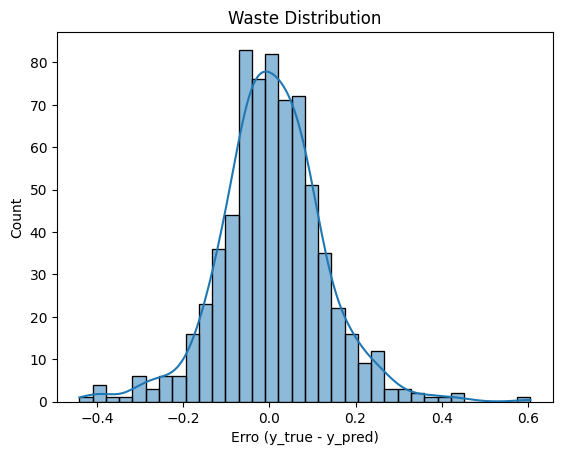

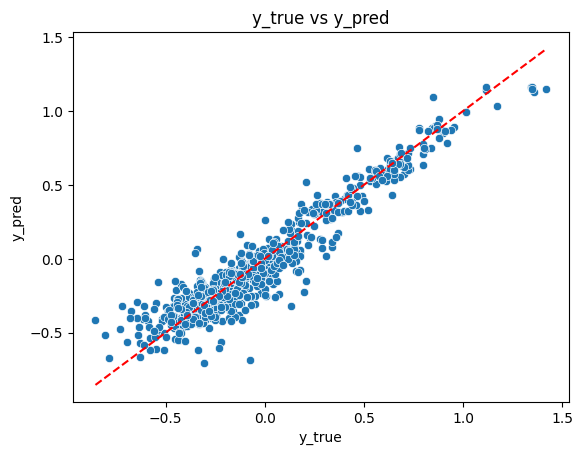

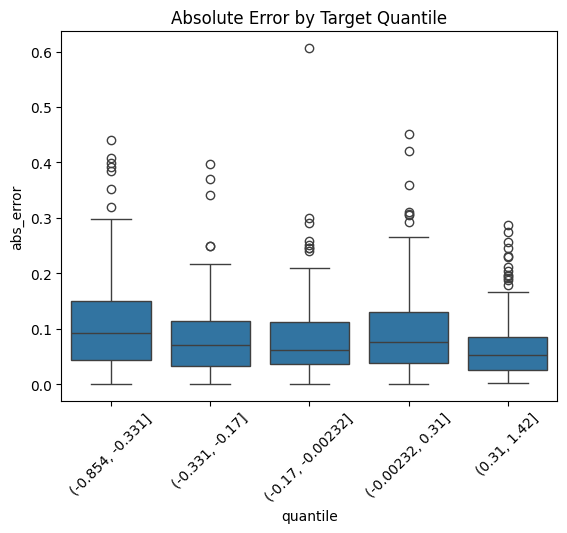

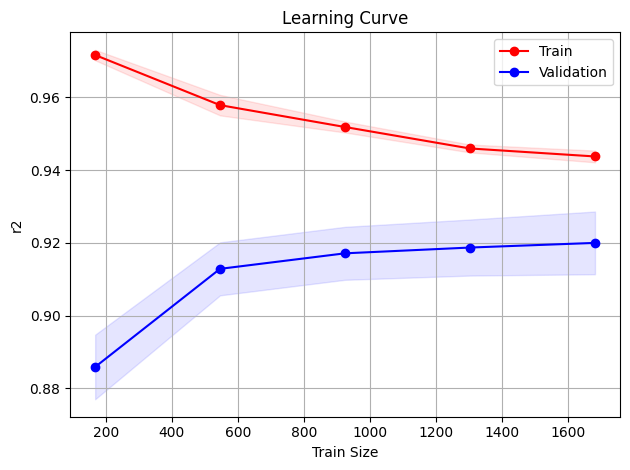

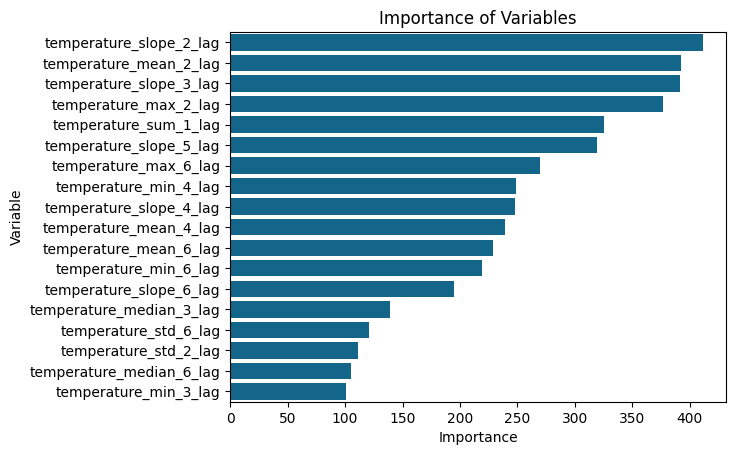

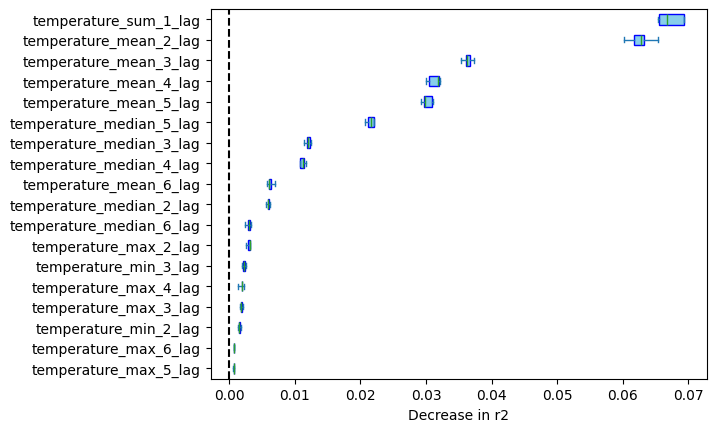

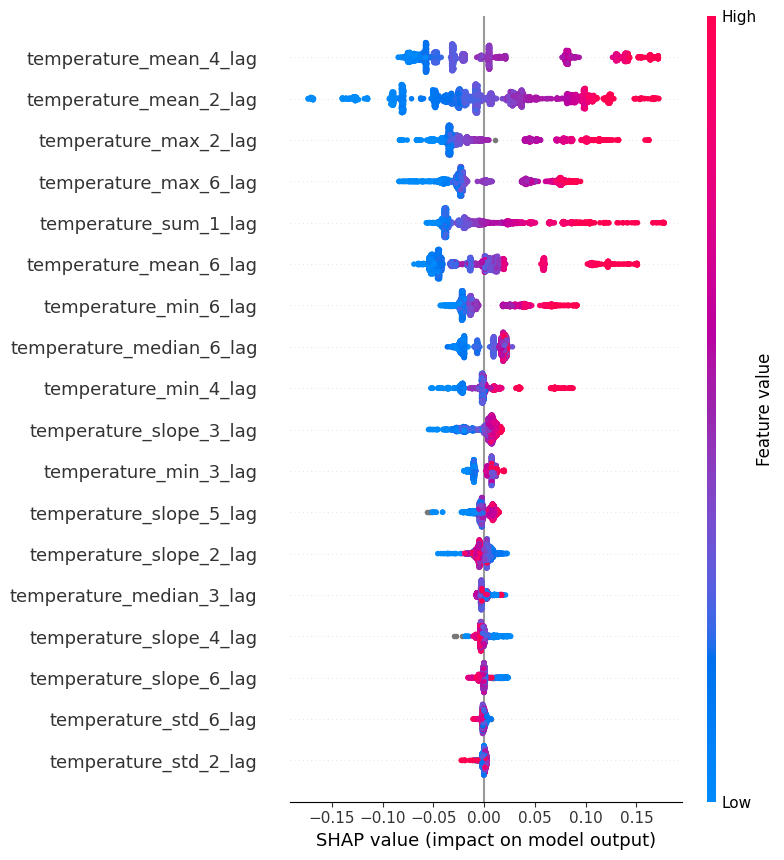

In [9]:
a.get_result_analysis()

In [10]:
acv = AutoMLLGBMRegressorCV(
    X_train, y_train, 
    X_test, y_test,
    target='temperature',
    cv=KFold(shuffle=True, random_state=42),
    best_features=best_features_reg,
    n_trials=50,
    scoring='mean_absolute_error',
    random_state=42
)

In [11]:
acv.train()

In [12]:
acv.get_metrics()

Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.912113  0.092205  0.073585  1.726054e+12  0.120596   
1      Test  0.897021  0.094788  0.070728  4.253654e+12  0.126819   
2  Train CV  0.914141  0.090843  0.068646  2.000160e+12  0.119219   
3      Test  0.899457  0.093677  0.069638  4.285147e+12  0.125310   
4  Train CV  0.920290  0.088532  0.070525  1.704549e+12  0.114893   
5      Test  0.906441  0.089726  0.066099  4.302705e+12  0.120879   

   Explained Variance               Model  
0            0.912306          Base Model  
1            0.897181          Base Model  
2            0.914378  Best Feature Model  
3            0.899700  Best Feature Model  
4            0.920497   Best Params Model  
5            0.906774   Best Params Model

base_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.912113  0.092205  0.073585  1.726054e+12  0.120596   
1      Test  0.897021  0.094788  0.070728  4.253654e+12  0.126819   

   Explained Variance  
0            0.912306  
1            0.897181

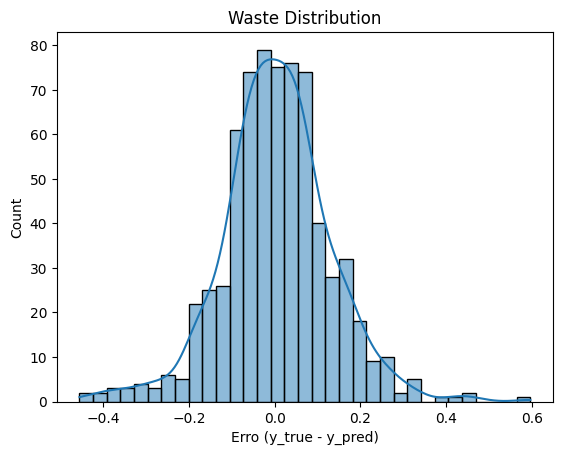

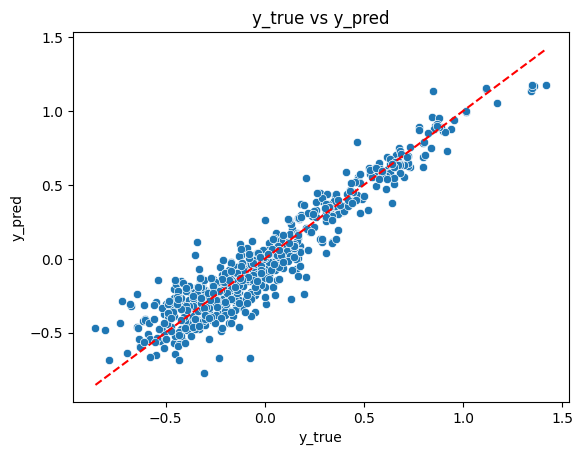

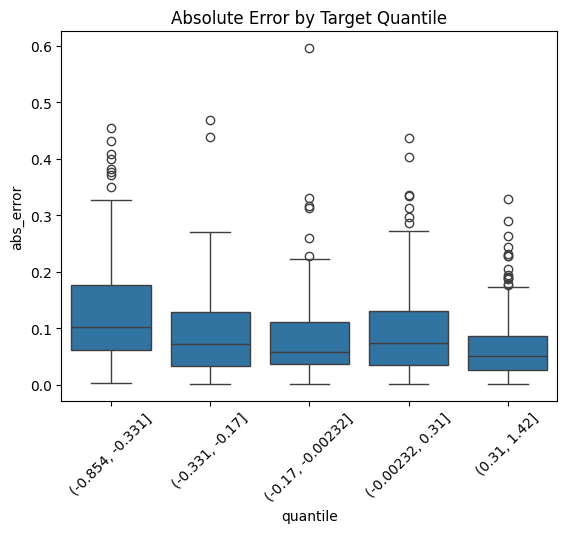

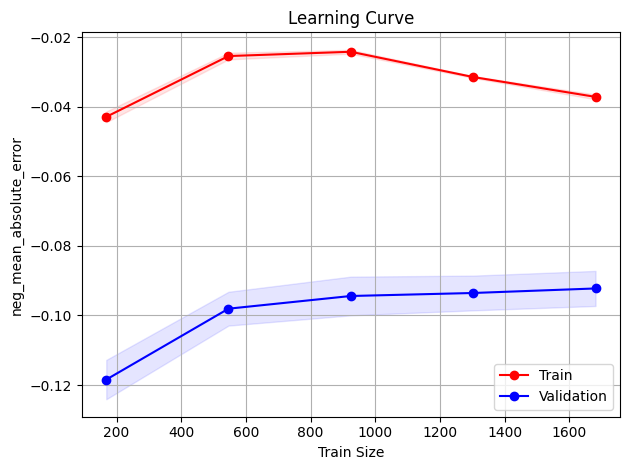

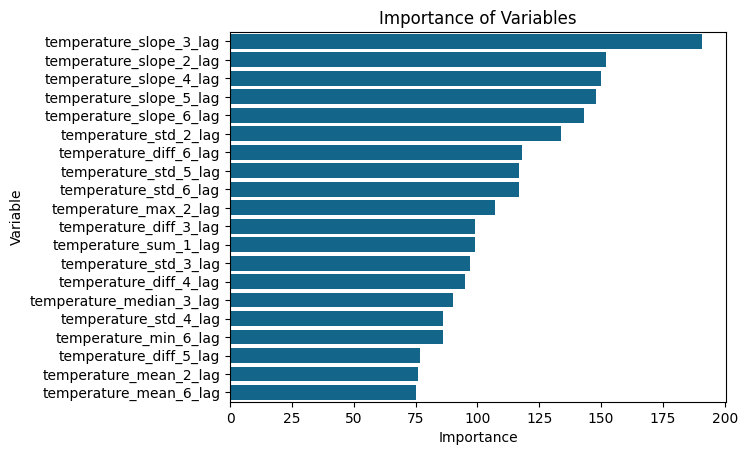

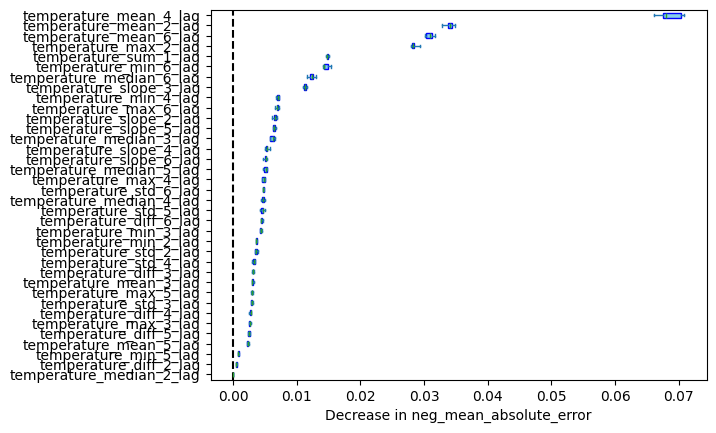

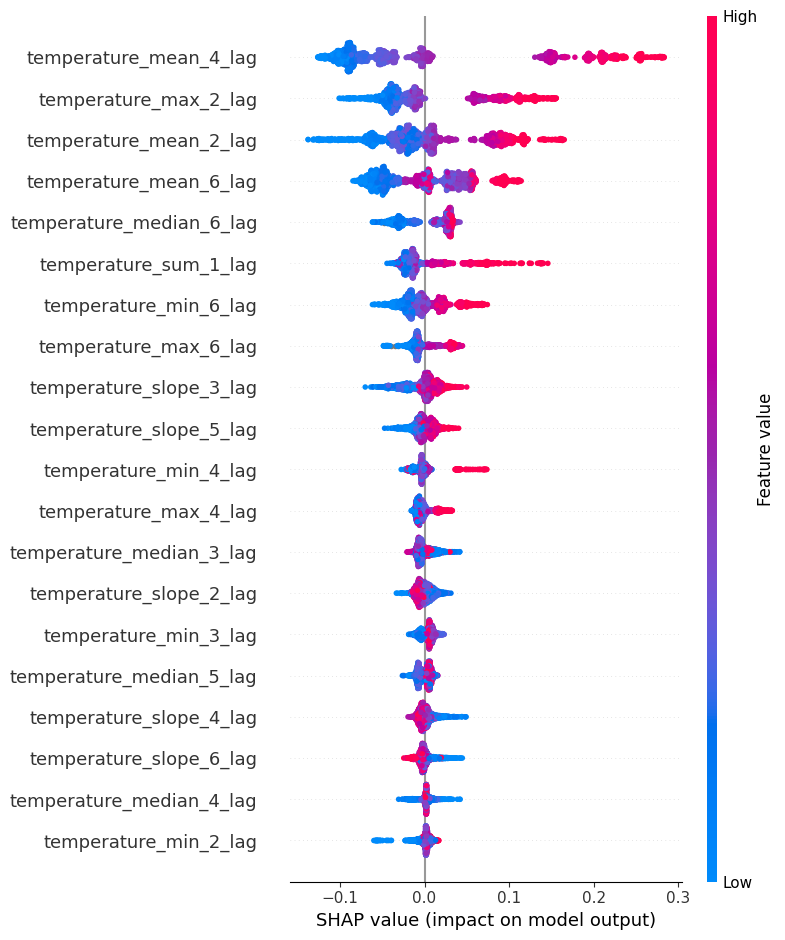

best_feature_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.914141  0.090843  0.068646  2.000160e+12  0.119219   
1      Test  0.899457  0.093677  0.069638  4.285147e+12  0.125310   

   Explained Variance  
0            0.914378  
1            0.899700

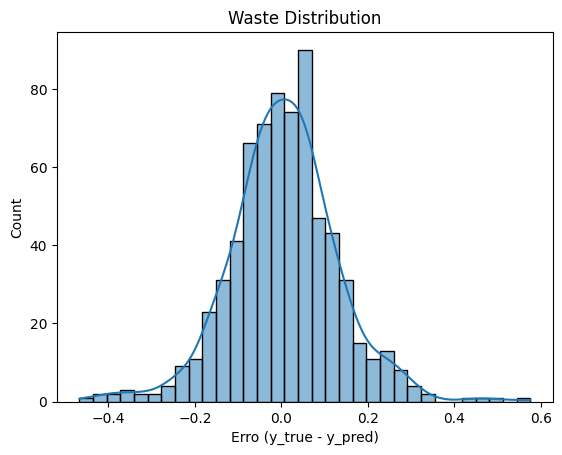

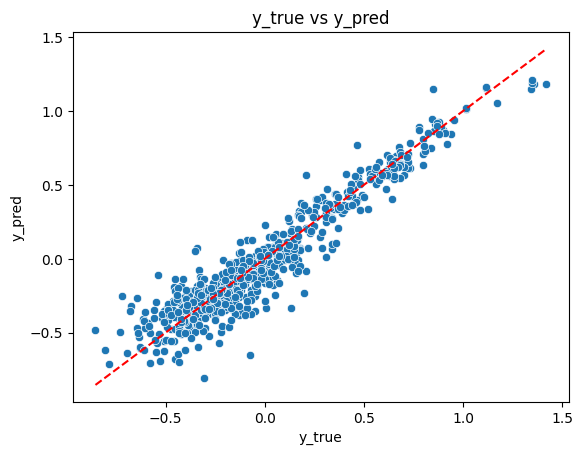

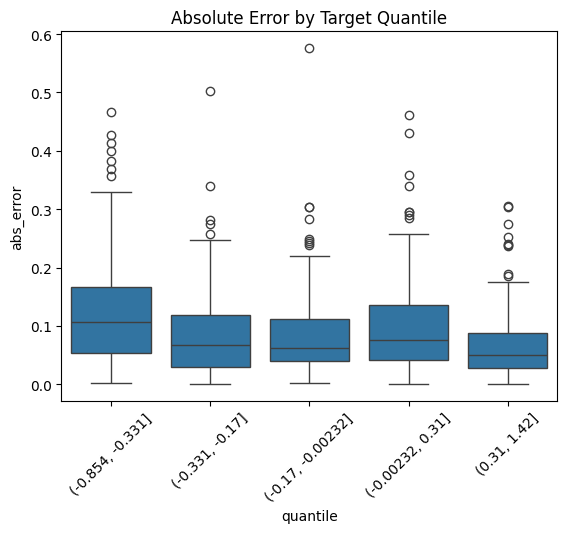

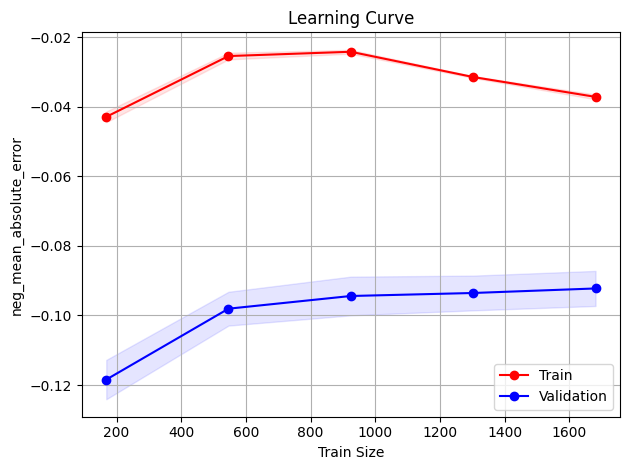

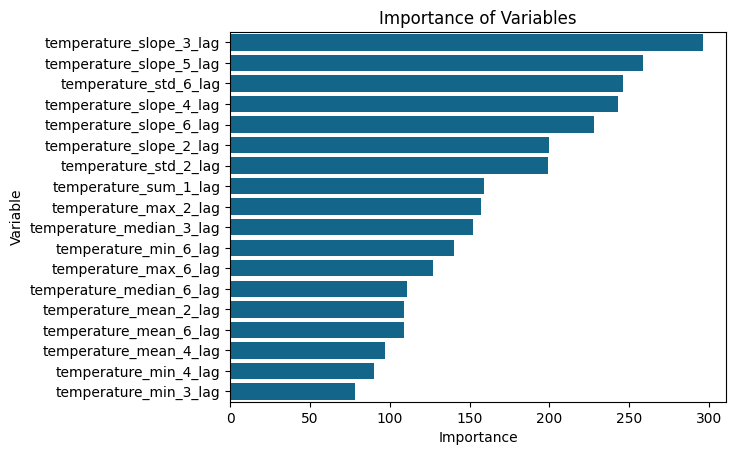

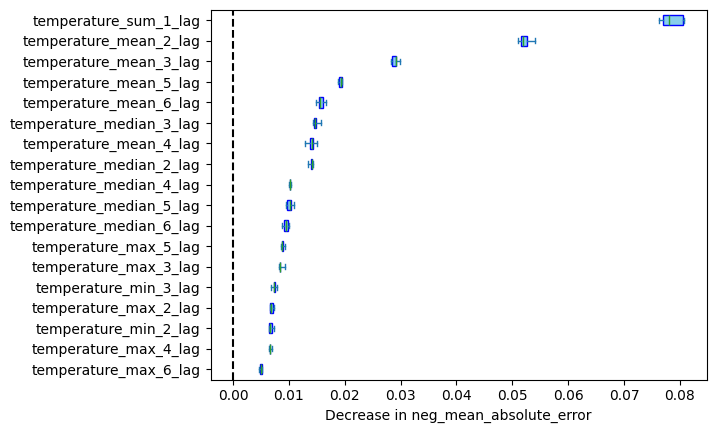

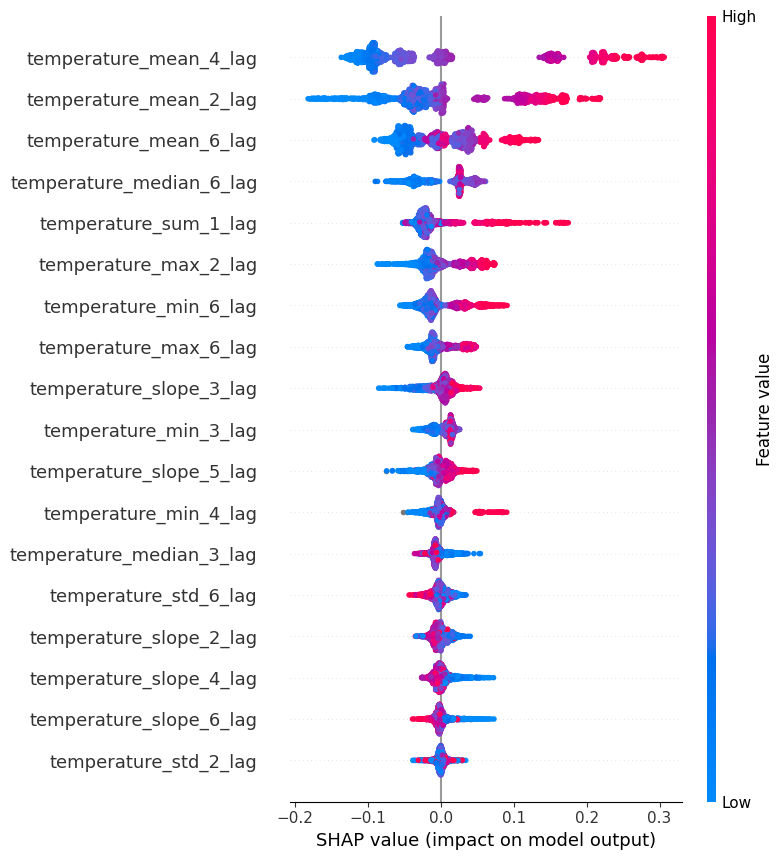

best_params_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.920290  0.088532  0.070525  1.704549e+12  0.114893   
1      Test  0.906441  0.089726  0.066099  4.302705e+12  0.120879   

   Explained Variance  
0            0.920497  
1            0.906774

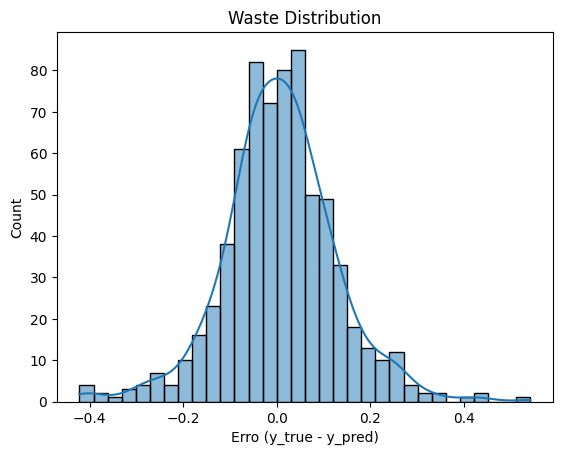

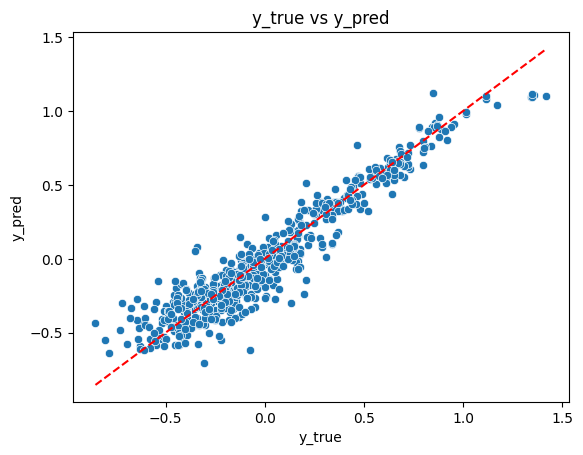

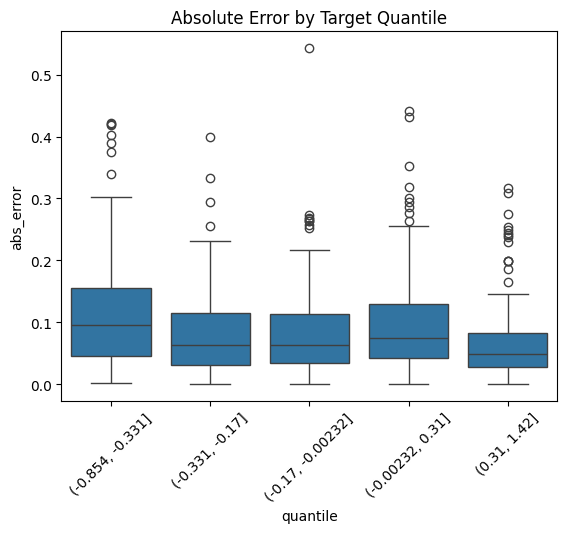

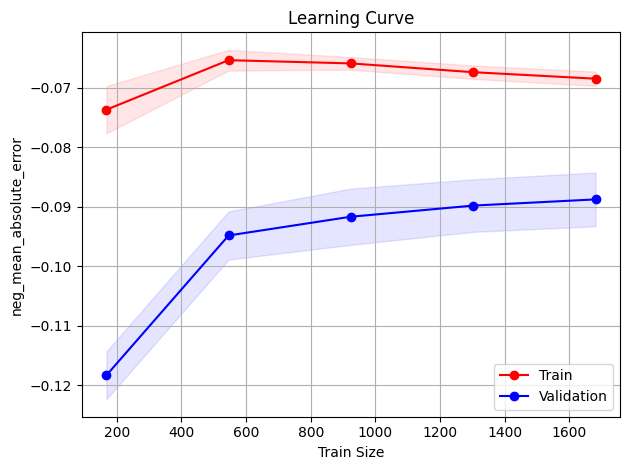

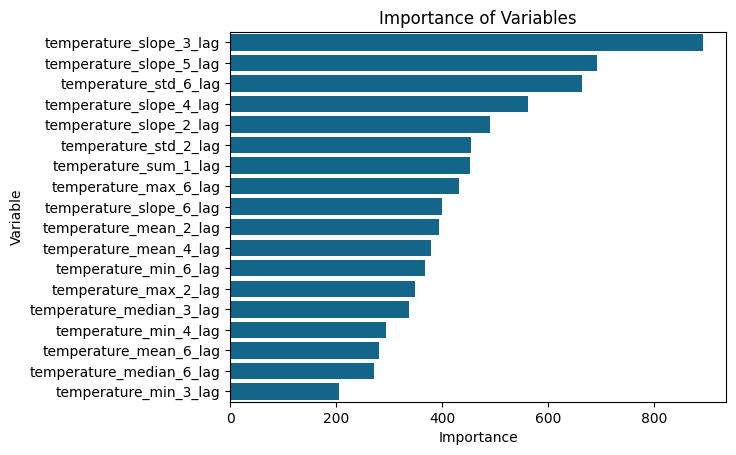

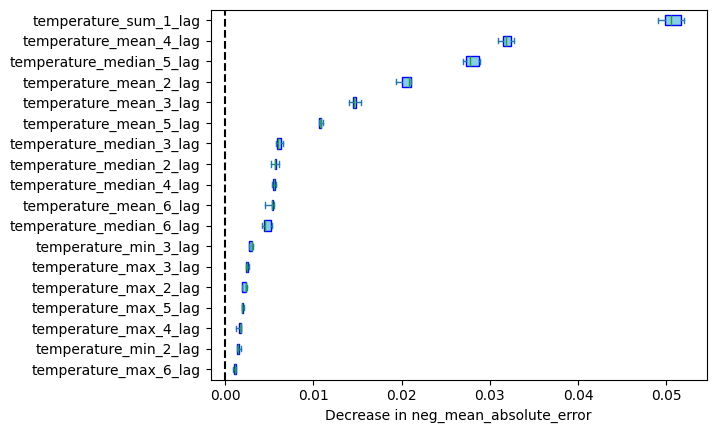

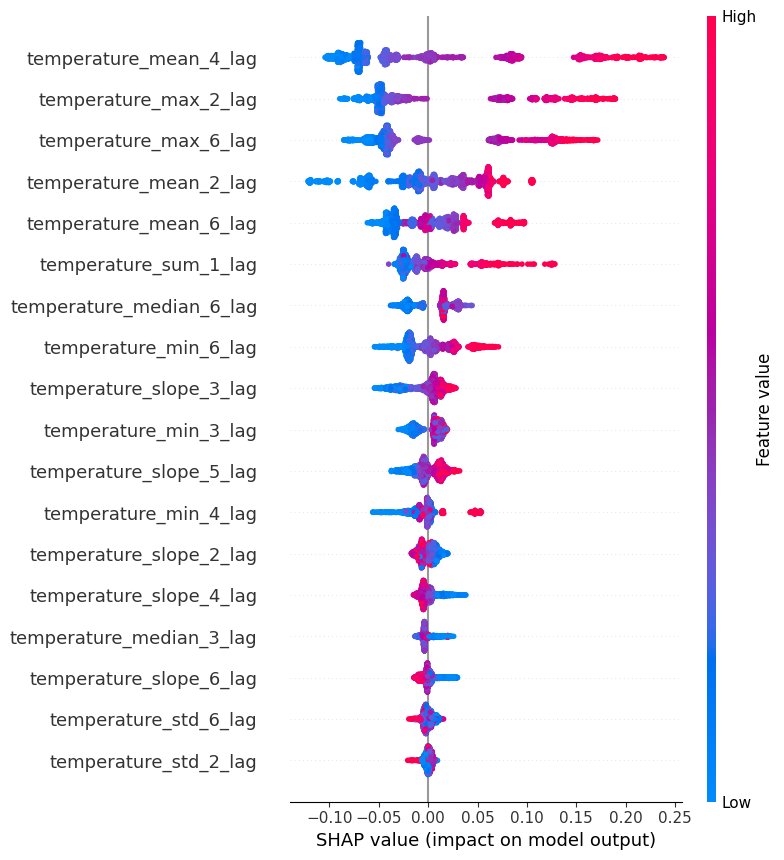

In [13]:
acv.get_result_analysis()

# Classifier

In [3]:
from dstoolkit.automl import AutoMLLGBMClassifier, AutoMLLGBMClassifierCV

In [4]:
df = pd.read_csv('../data/cs-training.csv')

X = df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = df[['SeriousDlqin2yrs']].rename({'SeriousDlqin2yrs': 'target'}, axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y['target'])
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42, stratify=y_temp['target'])

best_features_class = ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse', 'age', 'DebtRatio', 'MonthlyIncome']

In [5]:
a = AutoMLLGBMClassifier(
    X_train, y_train, 
    X_valid, y_valid, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    scoring='brier'
)

In [6]:
a.train()

In [7]:
a.get_metrics()

Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.246231           0.740497   0.477276  0.521941  0.498611   
1   Valid  0.195980           0.732529   0.400960  0.520781  0.453083   
2    Test  0.175879           0.736884   0.363294  0.541771  0.434935   
3   Train  0.216080           0.730571   0.445322  0.506316  0.473864   
4   Valid  0.226131           0.708750   0.429733  0.461347  0.444979   
5    Test  0.206030           0.704950   0.378749  0.464464  0.417250   
6   Train  0.206030           0.712786   0.412590  0.473903  0.441126   
7   Valid  0.195980           0.722009   0.406612  0.495844  0.446816   
8    Test  0.180905           0.722443   0.373561  0.505611  0.429669   

        AUC        KS     Brier               Model  
0  0.902256  0.644746  0.044558          Base Model  
1  0.867222  0.579020  0.048628          Base Model  
2  0.859473  0.557068  0.049605          Base Model  
3  0.892142  0.618199  0.046208  Best Feature Model  
4  0.856926  0.564522  0.049246  Best Feature Model  
5  0.850480  0.543173  0.050418  Best Feature Model  
6  0.865934  0.573926  0.048795   Best Params Model  
7  0.859932  0.568087  0.049165   Best Params Model  
8  0.852650  0.542539  0.050061   Best Params Model

base_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.246231           0.740497   0.477276  0.521941  0.498611   
1   Valid  0.195980           0.732529   0.400960  0.520781  0.453083   
2    Test  0.175879           0.736884   0.363294  0.541771  0.434935   

        AUC        KS     Brier  
0  0.902256  0.644746  0.044558  
1  0.867222  0.579020  0.048628  
2  0.859473  0.557068  0.049605

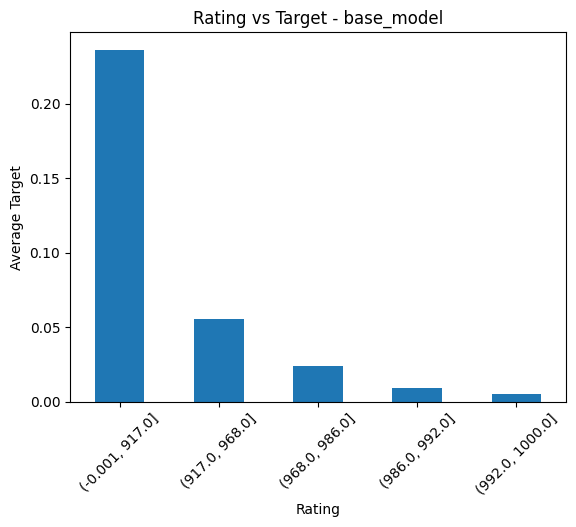

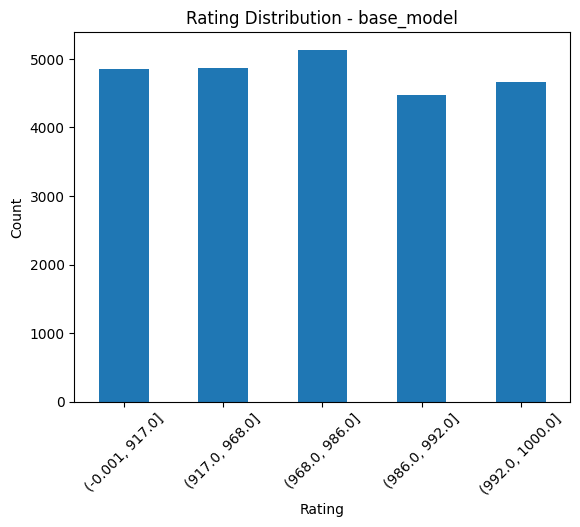

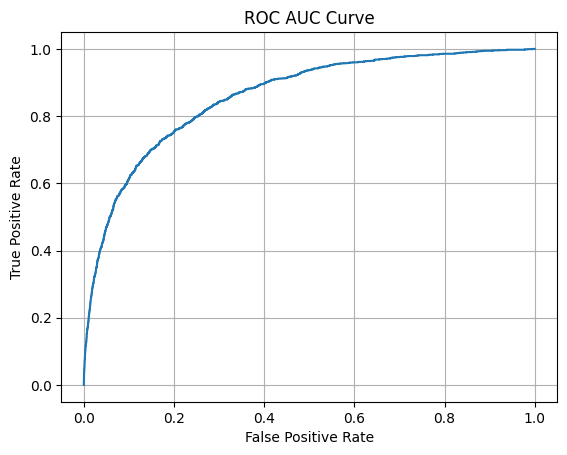

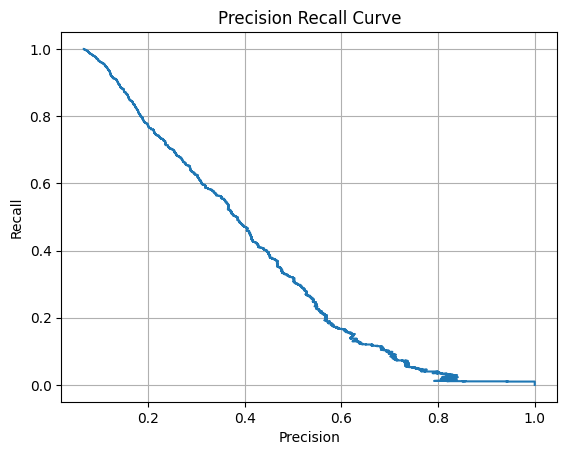

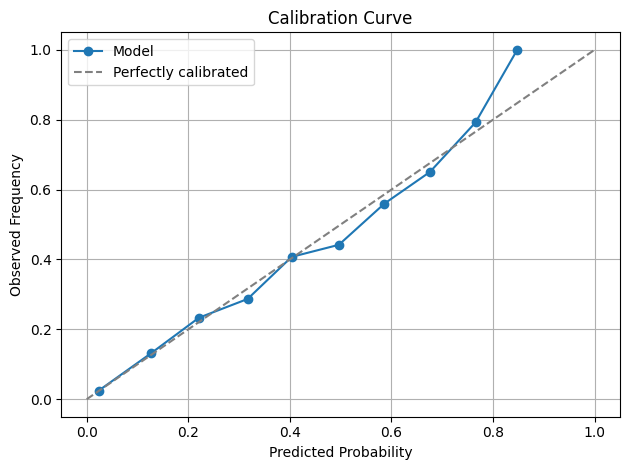

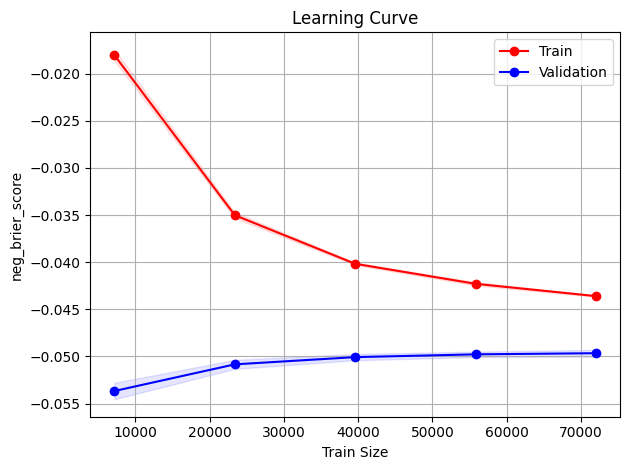

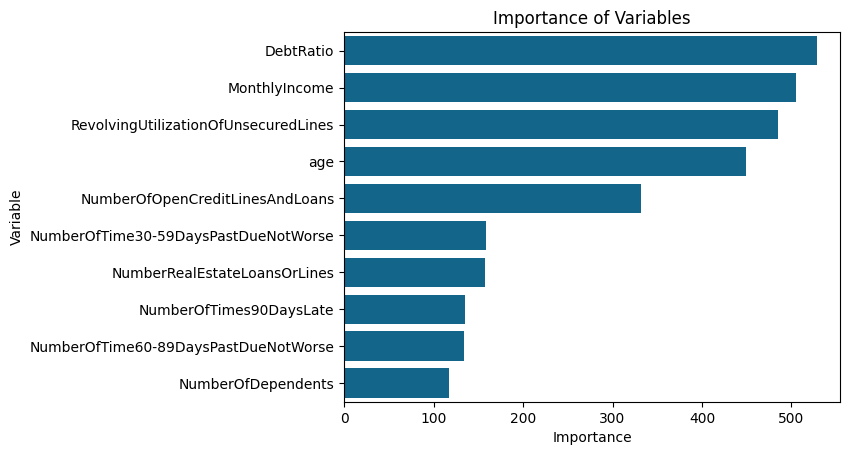

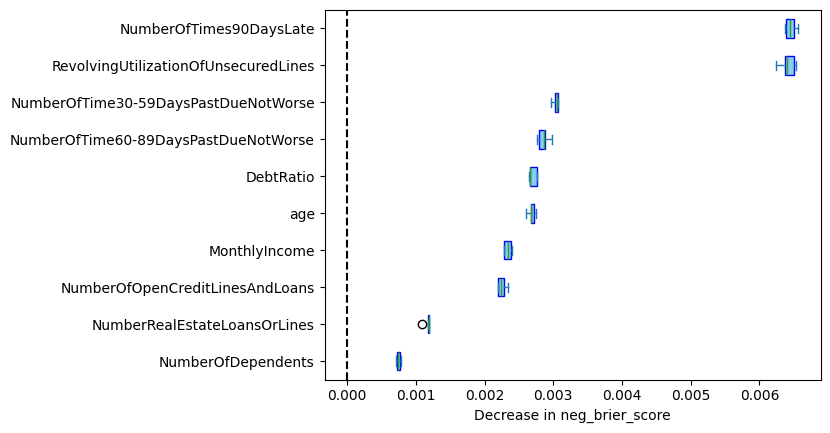

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


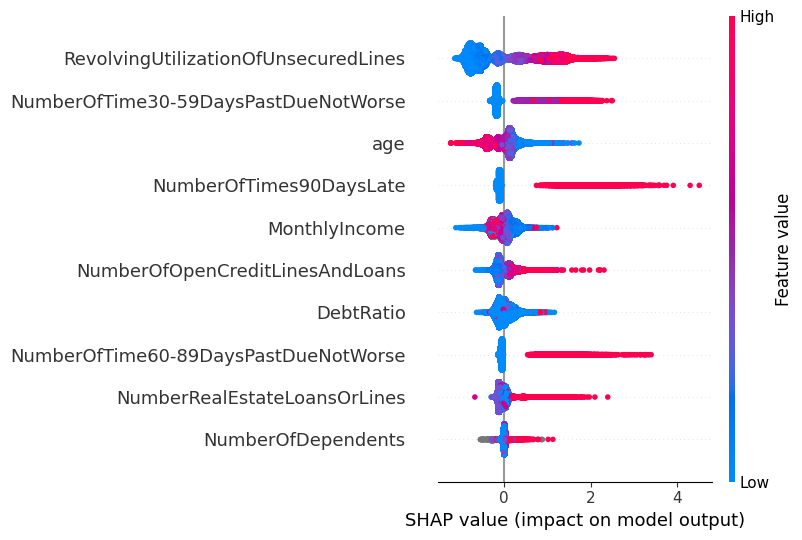

best_feature_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.216080           0.730571   0.445322  0.506316  0.473864   
1   Valid  0.226131           0.708750   0.429733  0.461347  0.444979   
2    Test  0.206030           0.704950   0.378749  0.464464  0.417250   

        AUC        KS     Brier  
0  0.892142  0.618199  0.046208  
1  0.856926  0.564522  0.049246  
2  0.850480  0.543173  0.050418

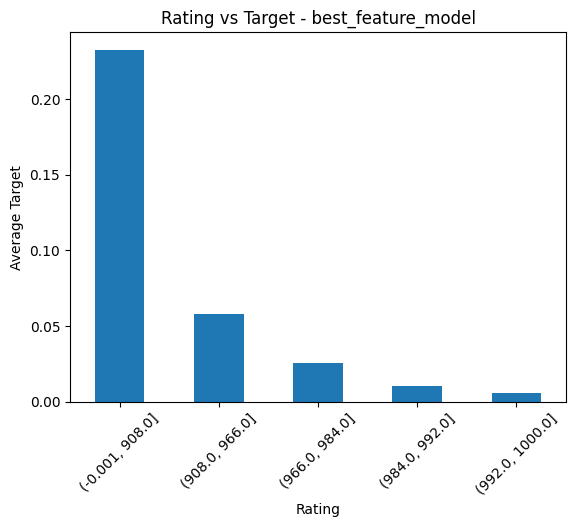

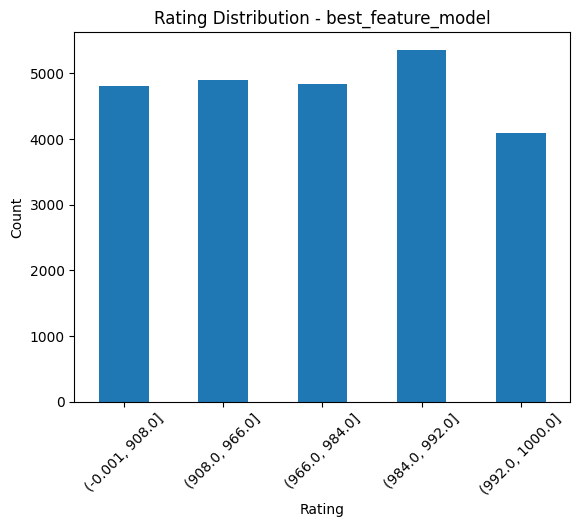

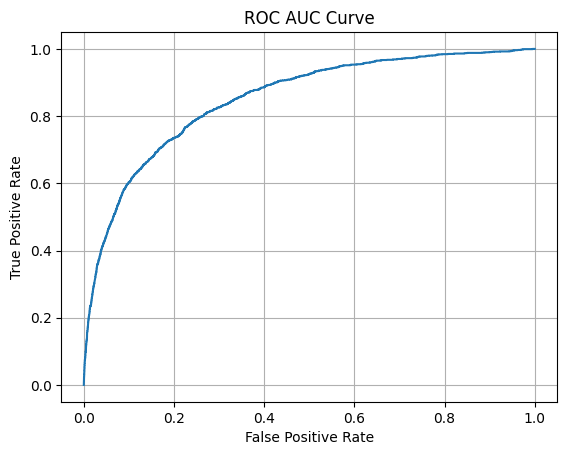

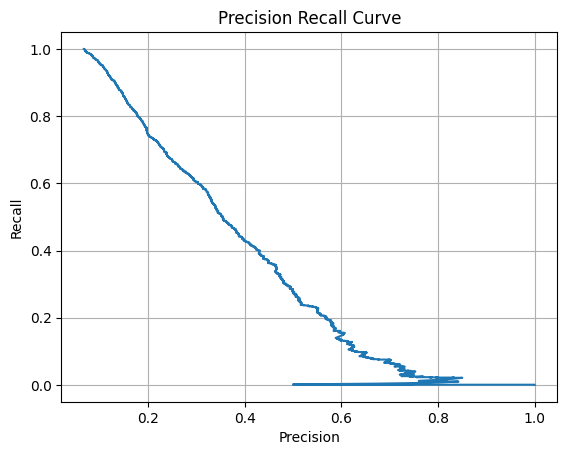

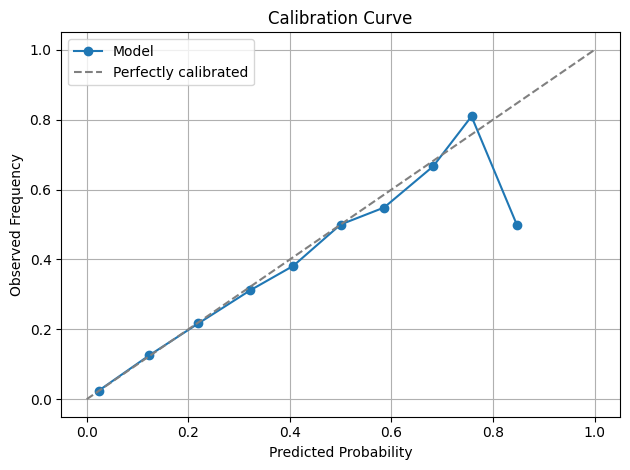

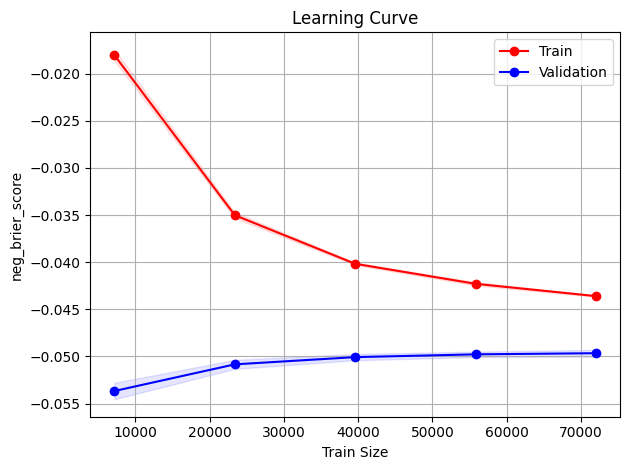

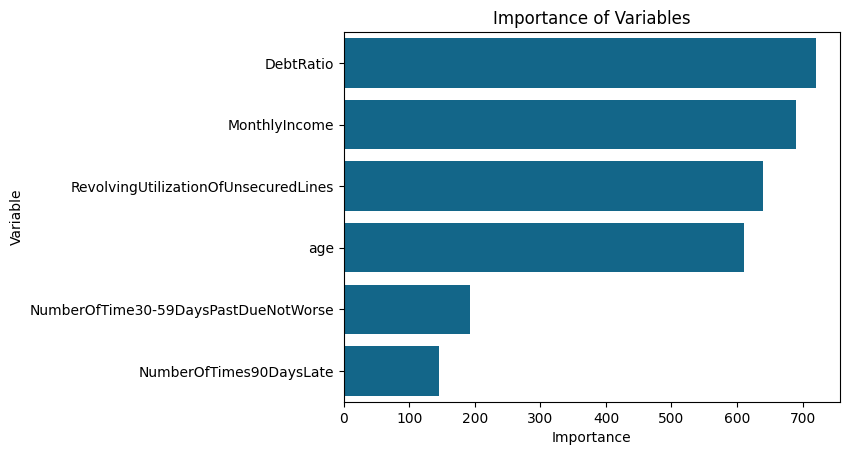

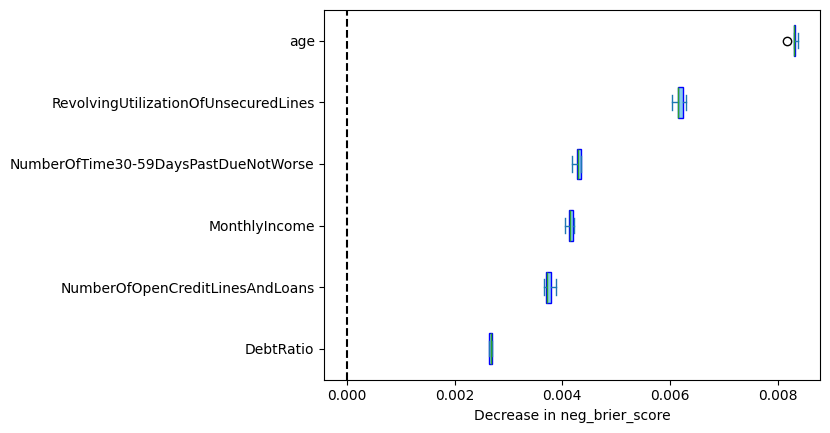

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


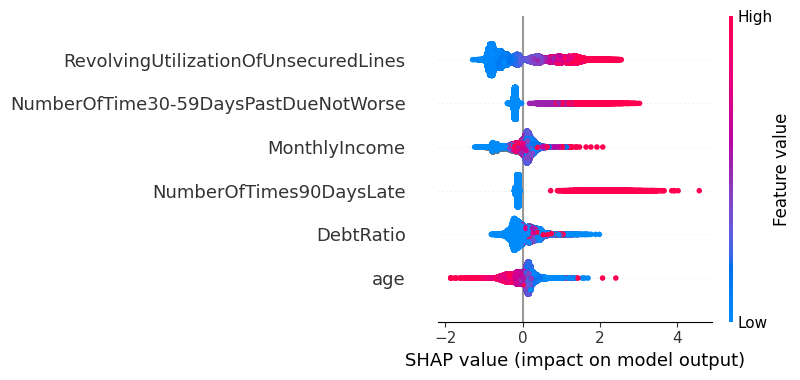

best_params_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.206030           0.712786   0.412590  0.473903  0.441126   
1   Valid  0.195980           0.722009   0.406612  0.495844  0.446816   
2    Test  0.180905           0.722443   0.373561  0.505611  0.429669   

        AUC        KS     Brier  
0  0.865934  0.573926  0.048795  
1  0.859932  0.568087  0.049165  
2  0.852650  0.542539  0.050061

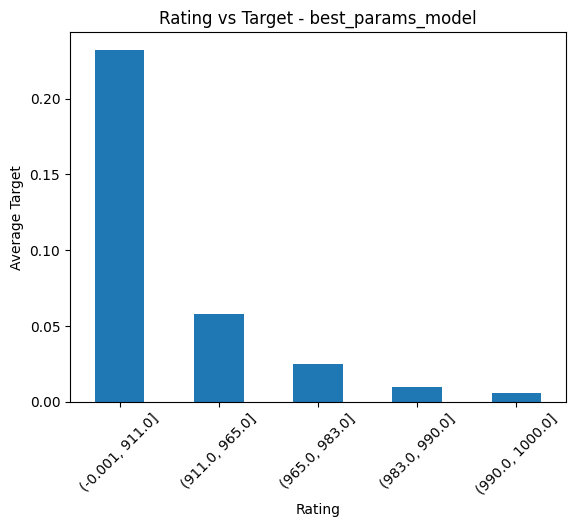

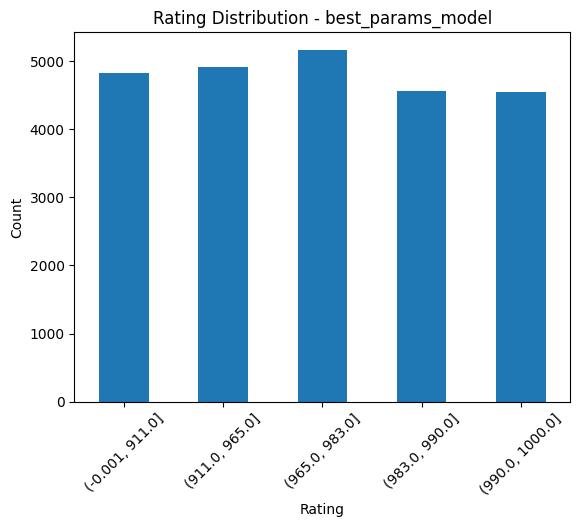

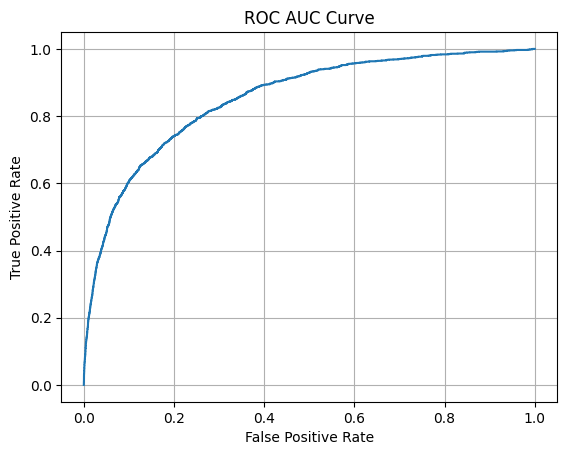

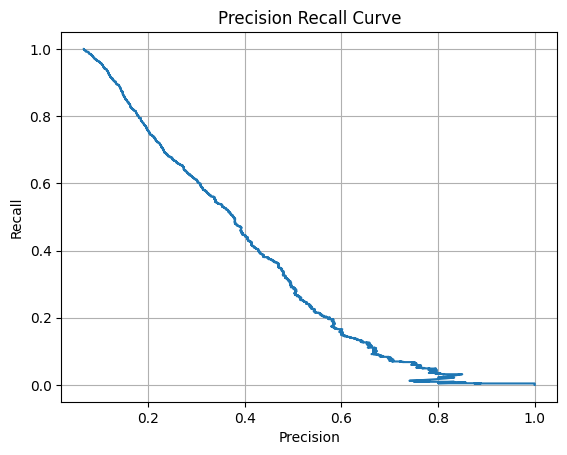

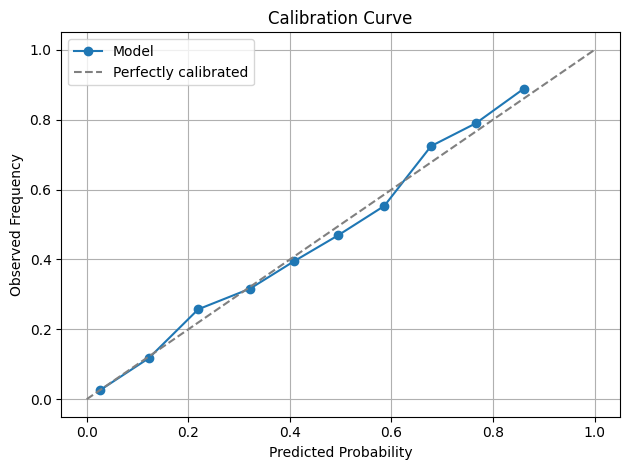

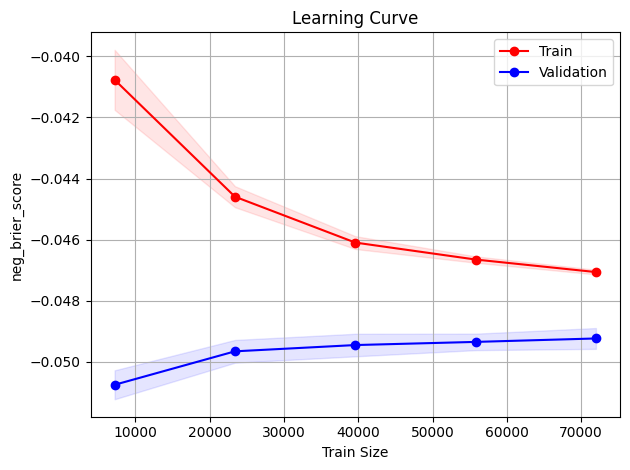

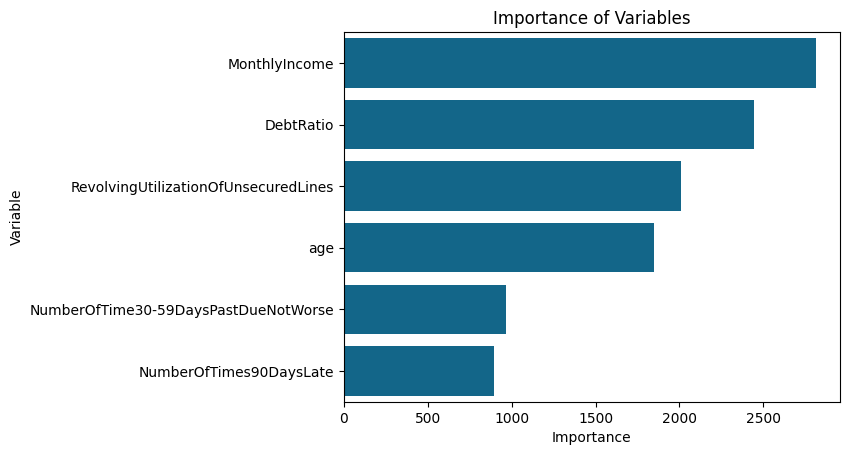

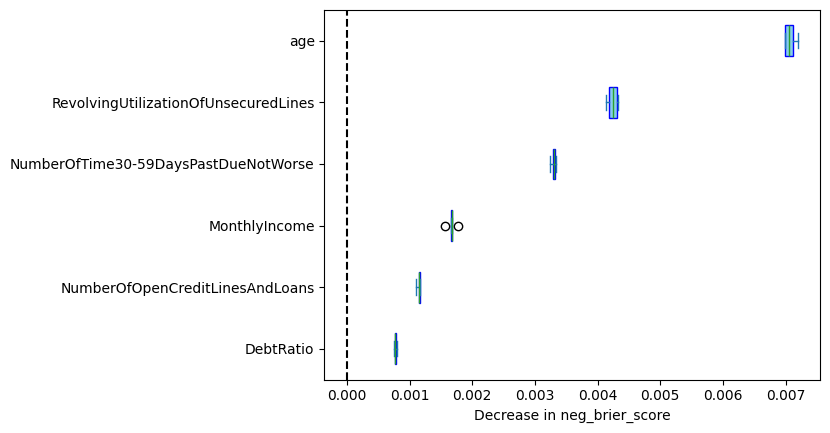

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


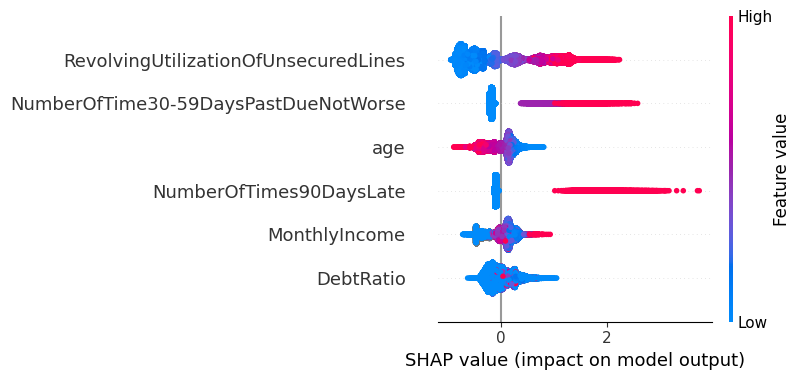

In [8]:
a.get_result_analysis()

In [9]:
acv = AutoMLLGBMClassifierCV(
    X_train, y_train, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='brier'
)

In [10]:
acv.train()

In [11]:
acv.get_metrics()

Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.586257   0.580235  0.182017  0.276759   
1      Test  0.175879           0.736884   0.363294  0.541771  0.434935   
2  Train CV  0.500000           0.575603   0.587542  0.159243  0.250263   
3      Test  0.206030           0.704950   0.378749  0.464464  0.417250   
4  Train CV  0.500000           0.575099   0.599866  0.157747  0.249719   
5      Test  0.195980           0.714924   0.383933  0.485661  0.428847   

        AUC        KS     Brier               Model  
0  0.861749  0.571792  0.049660          Base Model  
1  0.859473  0.557068  0.049605          Base Model  
2  0.850368  0.554540  0.050558  Best Feature Model  
3  0.850480  0.543173  0.050418  Best Feature Model  
4  0.853185  0.555186  0.050176   Best Params Model  
5  0.851936  0.544078  0.050004   Best Params Model

base_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.586257   0.580235  0.182017  0.276759   
1      Test  0.175879           0.736884   0.363294  0.541771  0.434935   

        AUC        KS     Brier  
0  0.861749  0.571792  0.049660  
1  0.859473  0.557068  0.049605

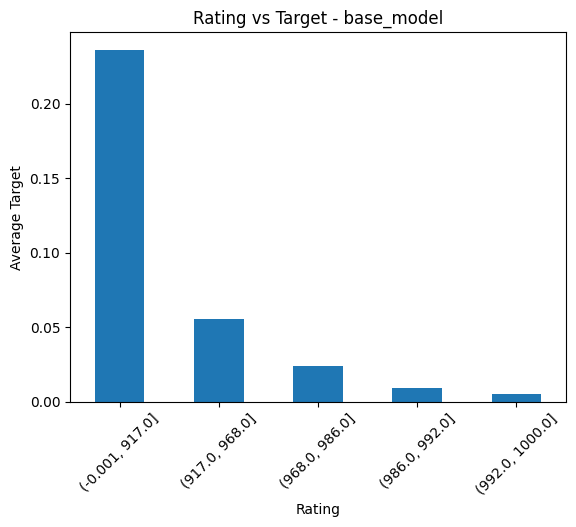

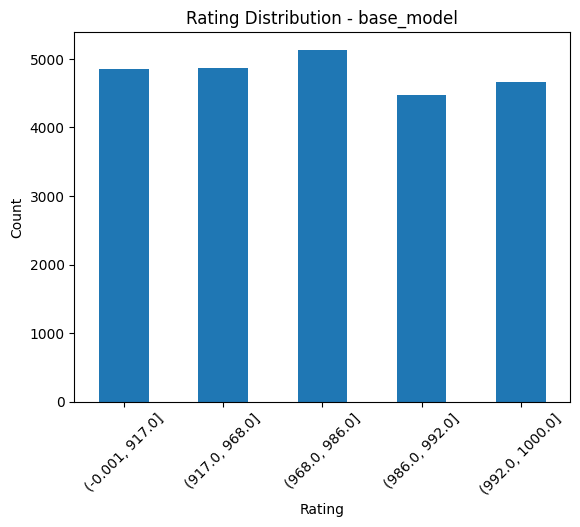

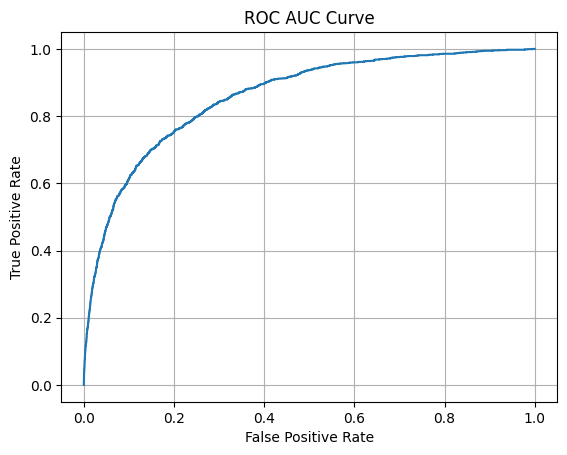

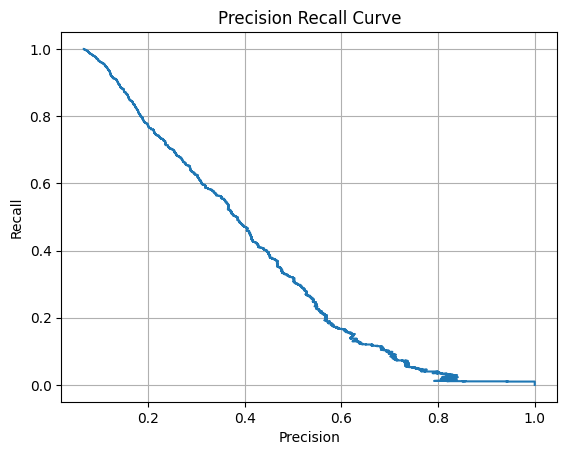

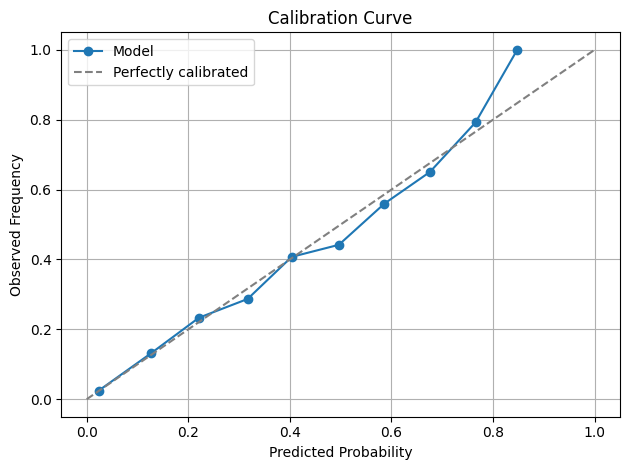

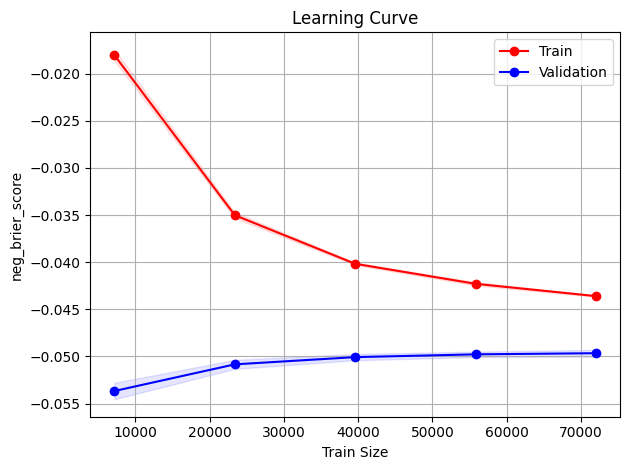

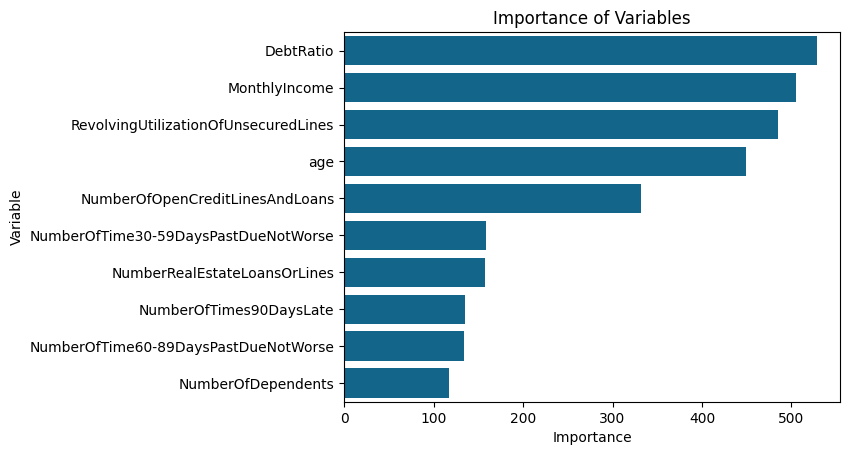

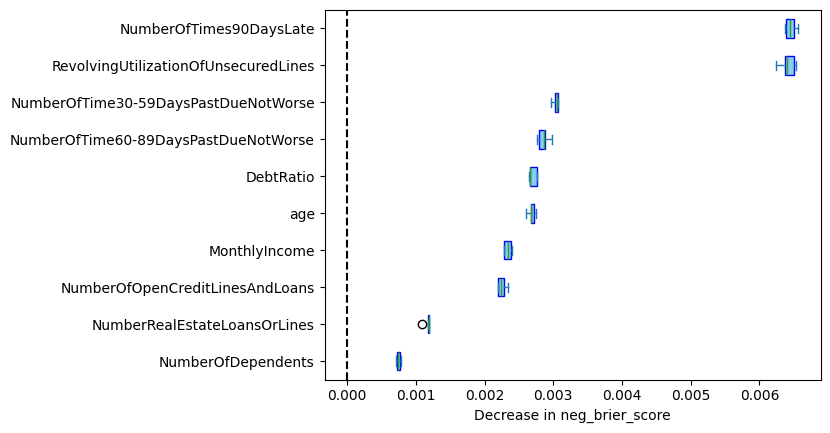

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


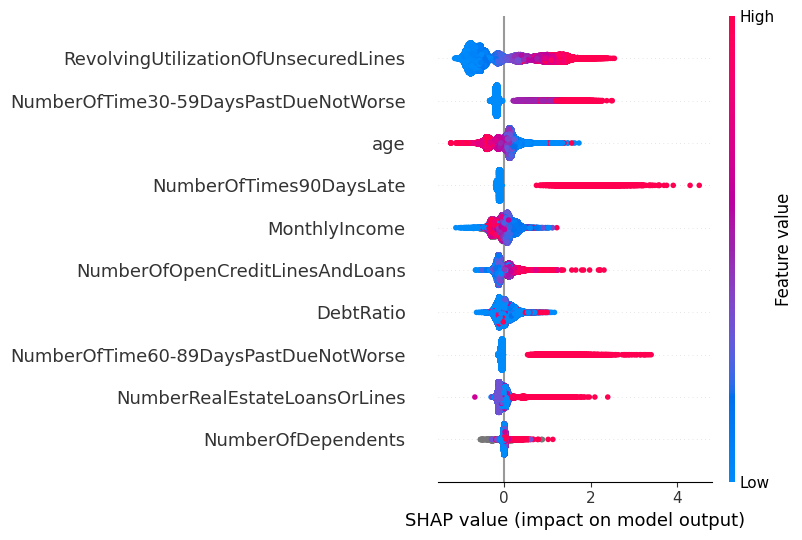

best_feature_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV   0.50000           0.575603   0.587542  0.159243  0.250263   
1      Test   0.20603           0.704950   0.378749  0.464464  0.417250   

        AUC        KS     Brier  
0  0.850368  0.554540  0.050558  
1  0.850480  0.543173  0.050418

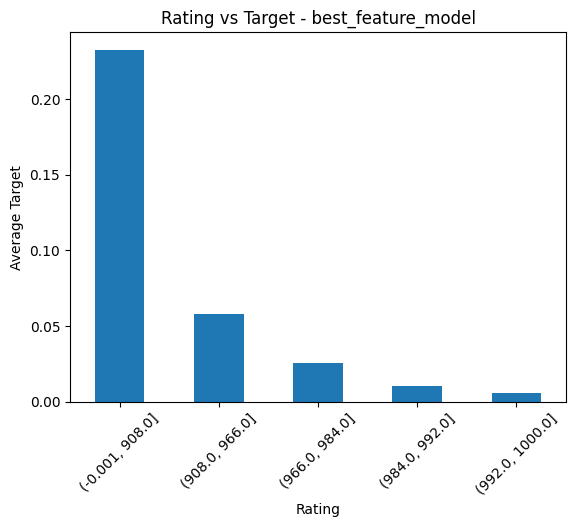

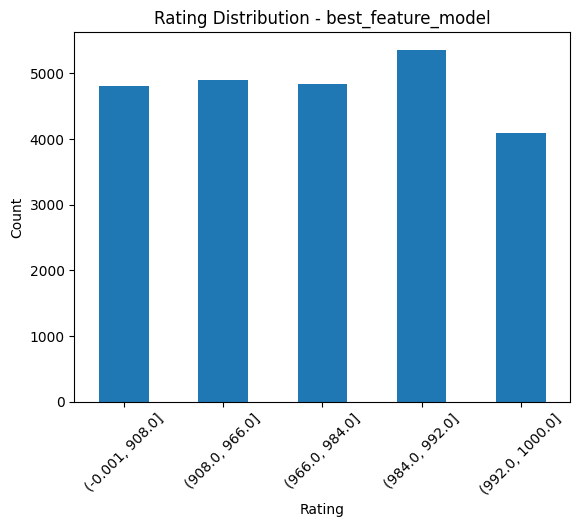

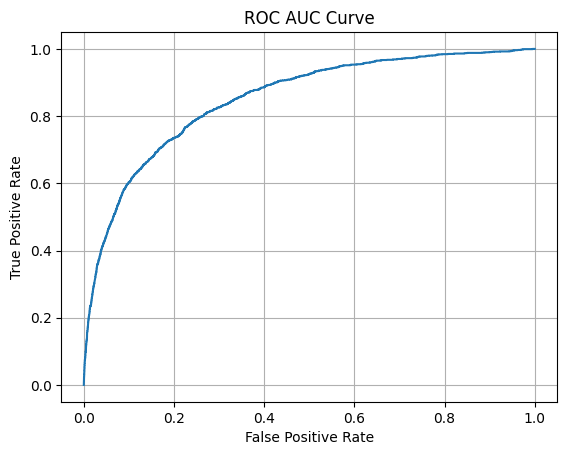

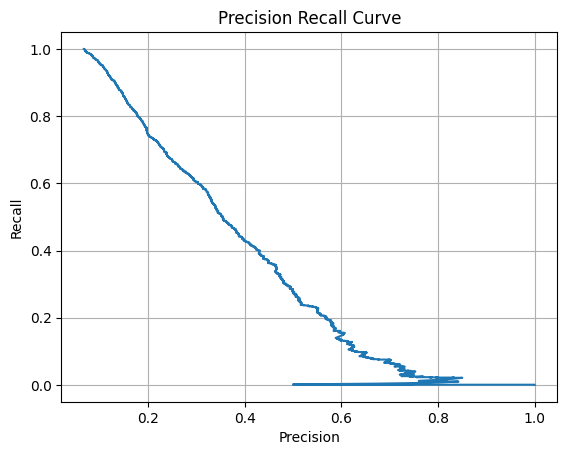

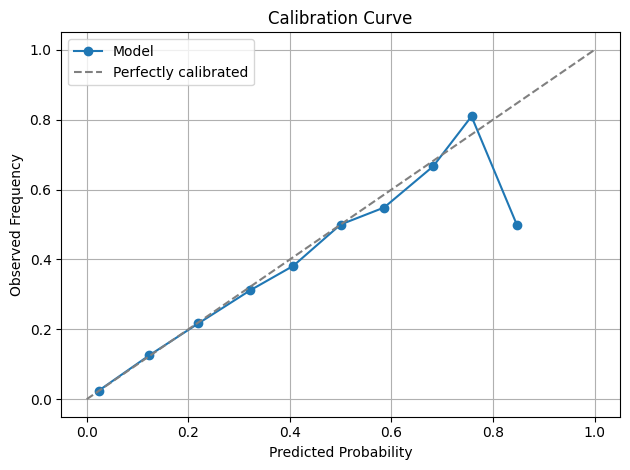

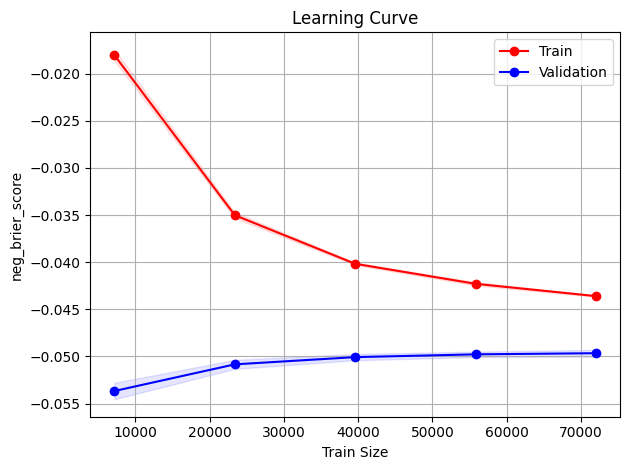

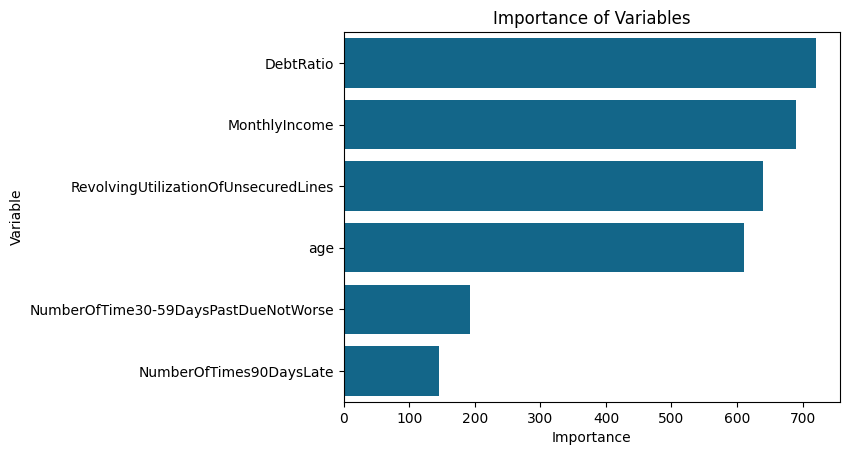

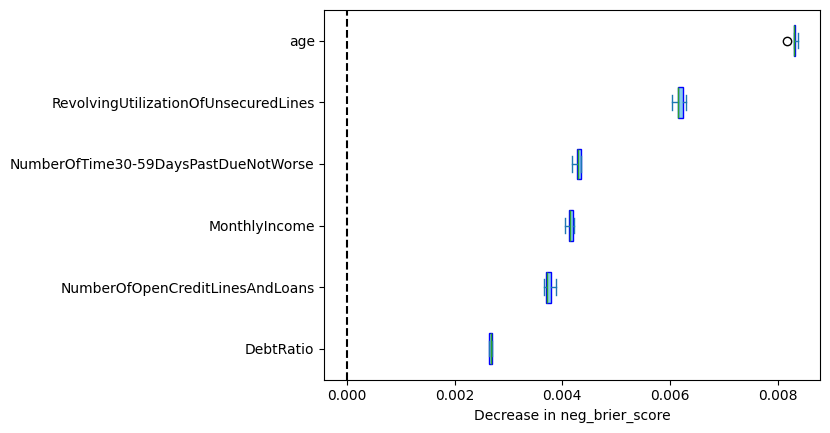

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


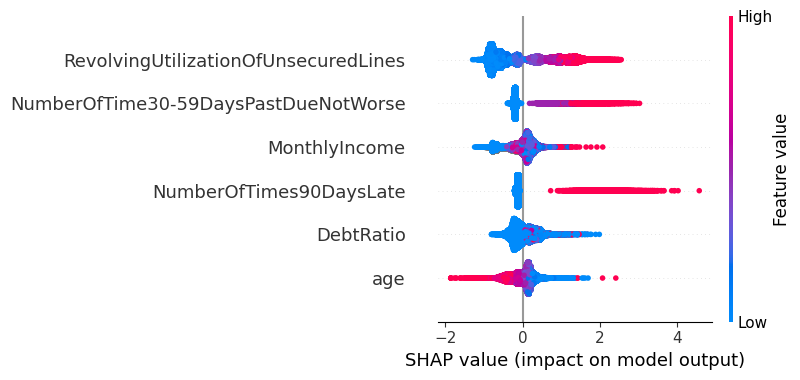

best_params_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV   0.50000           0.575099   0.599866  0.157747  0.249719   
1      Test   0.19598           0.714924   0.383933  0.485661  0.428847   

        AUC        KS     Brier  
0  0.853185  0.555186  0.050176  
1  0.851936  0.544078  0.050004

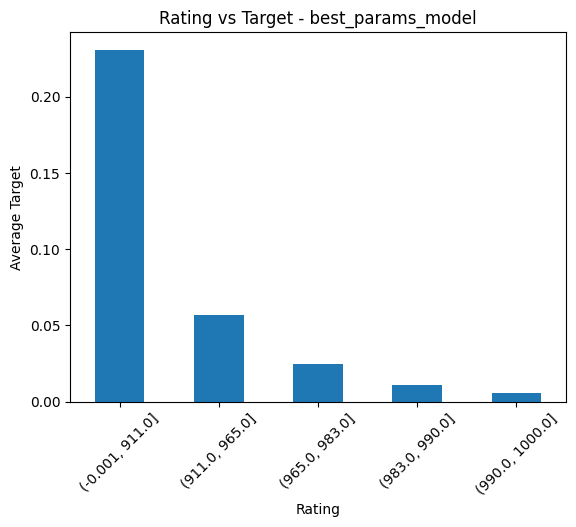

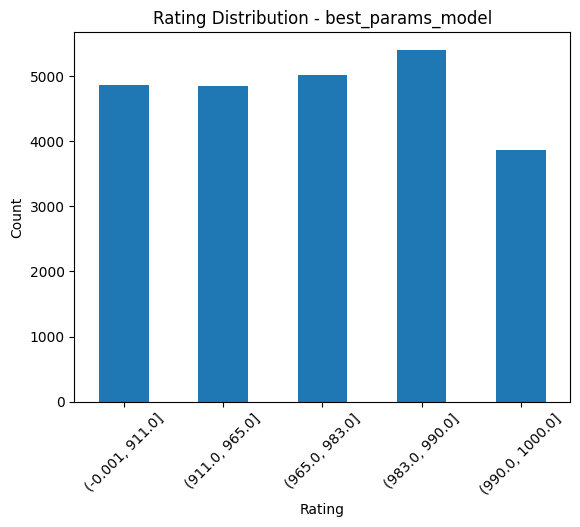

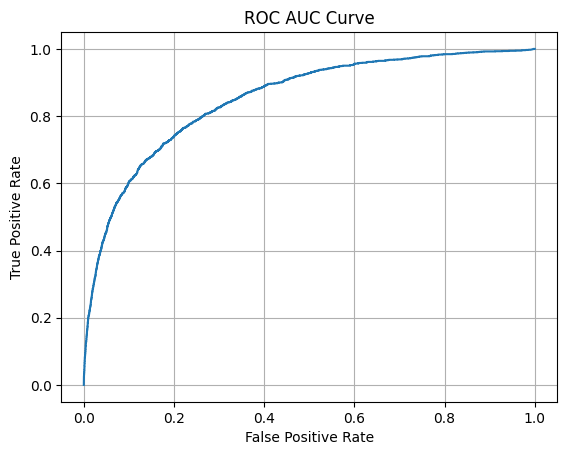

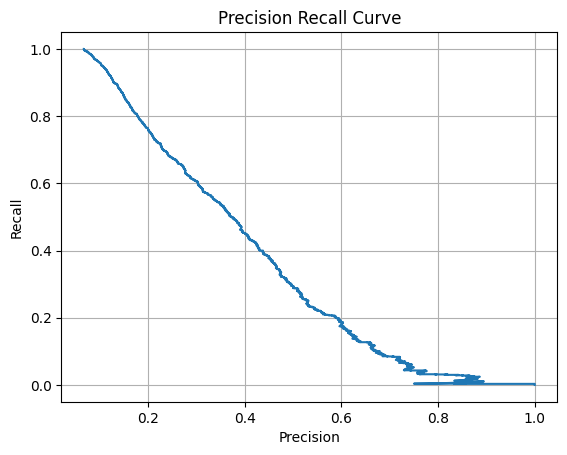

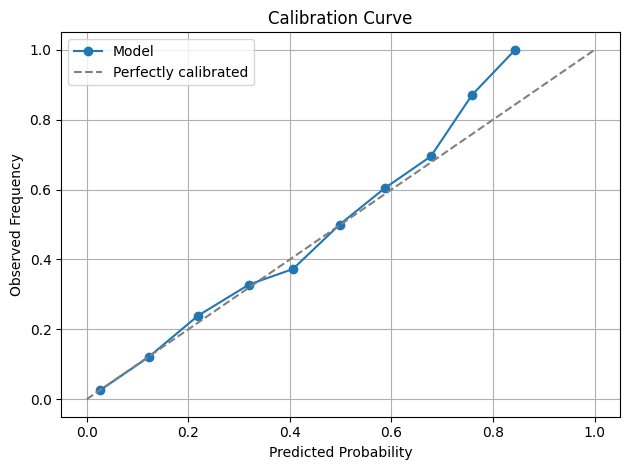

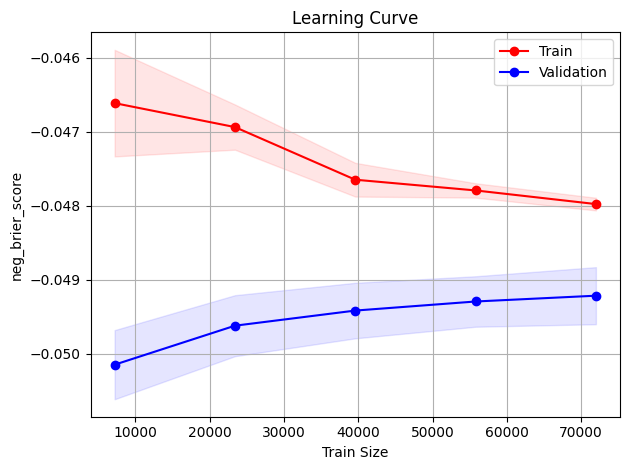

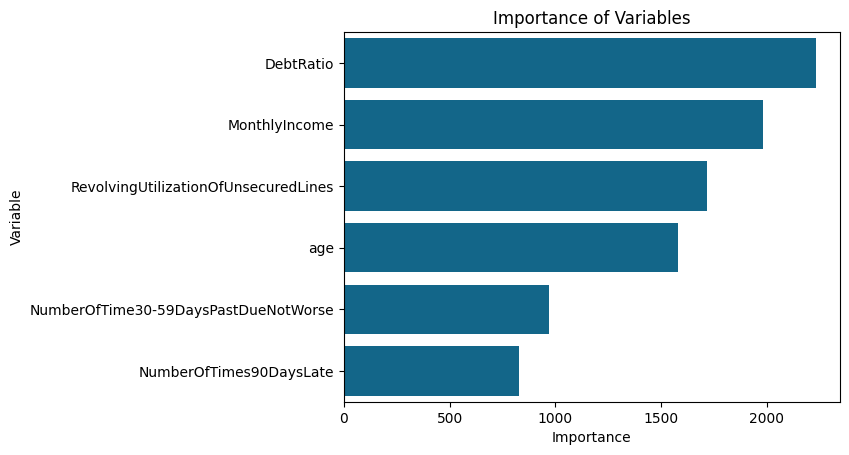

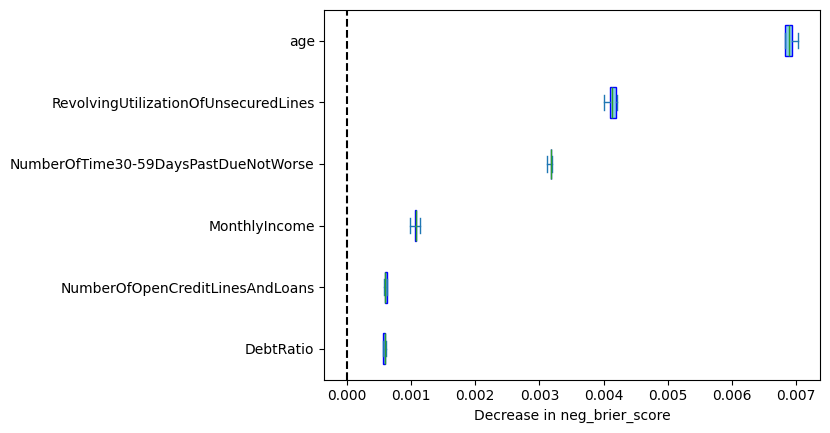

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


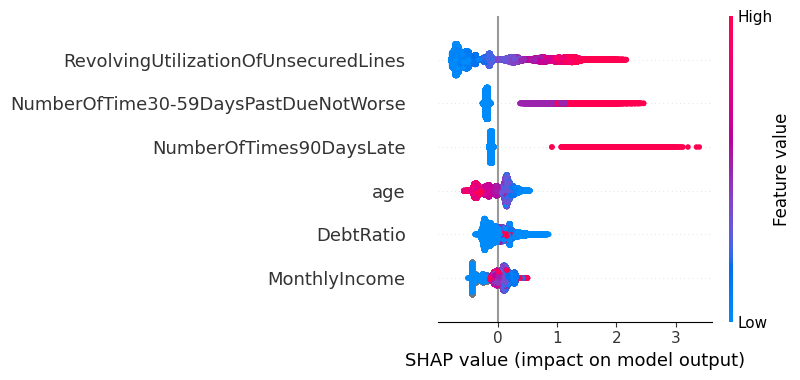

In [12]:
acv.get_result_analysis()